

This notebook contains my test results on Datasets 1, 2, 3, 4, 5, and 6. The test results for Dataset 4 are presented in a separate file.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, Dropout, InputLayer, Conv2D, MaxPooling2D, BatchNormalization, Input
import pandas as pd
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.ticker as mtick
from matplotlib import pyplot as plt



In this part of the code, the Transformer model was trained without the BiLSTM component. In the later sections, I extended the model by integrating BiLSTM with the Transformer, which forms my final proposed model.


DS1

<ipython-input-15-f81c237a4edb>:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_location=device))


Sensitivity:     83.11%
Specificity:     91.69%
Accuracy:        87.50%
F1 Score:        86.65%
MCC:             75.18%
auROC:           87.10%


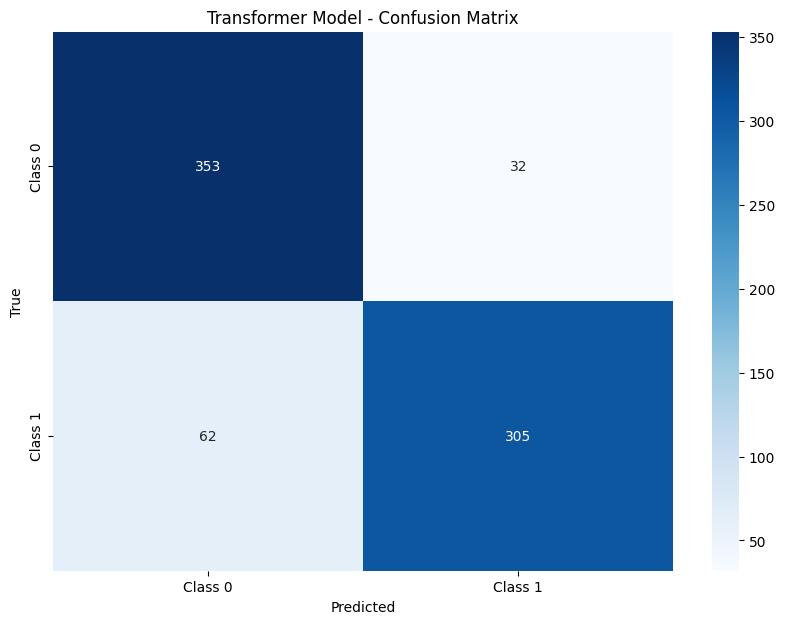

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt
import os

# تعریف مدل ترنسفورمر مشابه مدل آموزش‌دیده
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2):
        super(TransformerModel, self).__init__()
        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=input_dim, num_heads=num_heads) for _ in range(num_layers)
        ])
        self.layer_norm = nn.LayerNorm(input_dim)
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            x, _ = attention(x, x, x)
        x = x.transpose(0, 1)  # بازگشت به شکل اولیه
        x = self.layer_norm(x)
        x = torch.mean(x, dim=1)  # GlobalAveragePooling
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)       # اعمال Dropout
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

# تعریف دیتاست تست
class CustomTestDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.data[idx], dtype=torch.float32)

# بارگذاری داده‌های تست
def load_test_data_as_dataloader(file_paths, labels=None, batch_size=32):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)
    dataset = CustomTestDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# تابع برای پیش‌بینی با مدل PyTorch
def test_transformer_model(test_loader, model_load_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    input_dim = 1024  # ابعاد ورودی داده‌ها
    num_classes = 2   # تعداد کلاس‌ها
    model = TransformerModel(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    # بارگذاری وزن‌های مدل
    model.load_state_dict(torch.load(model_load_path, map_location=device))
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy()[:, 1])  # استخراج احتمال برچسب مثبت

    all_probs = np.array(all_probs)
    return np.array(all_labels), np.array(all_predictions), all_probs

# مسیر فایل‌های تست
test_save_paths_X = [
    '/content/drive/MyDrive/resized_X_TEST.npy'
]

# بارگذاری برچسب‌های تست
y_test = np.array(np.loadtxt('/content/drive/MyDrive/y_test_final.csv', delimiter=',', dtype=int))

# آماده‌سازی داده‌ها به عنوان DataLoader برای تست
test_loader = load_test_data_as_dataloader(test_save_paths_X, labels=y_test, batch_size=32)

# مسیر مدل ذخیره شده
model_load_path = '/content/drive/MyDrive/transformer_model_final1.pth'

# تست مدل
y_true, y_pred_labels, predicted_probs = test_transformer_model(test_loader, model_load_path)

# محاسبه و نمایش معیارهای عملکرد
def calculate_metrics(y_true, y_pred_labels, y_pred_probs):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    accuracy = accuracy_score(y_true, y_pred_labels) * 100
    f1 = f1_score(y_true, y_pred_labels) * 100
    mcc = matthews_corrcoef(y_true, y_pred_labels) * 100
    auroc = roc_auc_score(y_true, y_pred_probs) * 100
    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")
    print(f"auROC:           {auroc:.2f}%")

calculate_metrics(y_true, y_pred_labels, predicted_probs)

# نمایش ماتریس اختلاط و ذخیره تصویر
def display_conf_matrix(y_true, y_pred_labels, title, filename):
    cm = confusion_matrix(y_true, y_pred_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

# ایجاد دایرکتوری Figures در صورت عدم وجود
output_dir = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/Figuresfinal'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# نمایش ماتریس اختلاط و ذخیره تصویر
output_file = os.path.join(output_dir, 'Transformer_Model_CM.png')
display_conf_matrix(y_true, y_pred_labels, 'Transformer Model - Confusion Matrix', output_file)


<ipython-input-2-5c546afb4cb3>:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_location=device))


Sensitivity:     83.11%
Specificity:     91.69%
Accuracy:        87.50%
F1 Score:        86.65%
MCC:             75.18%
auROC:           87.10%


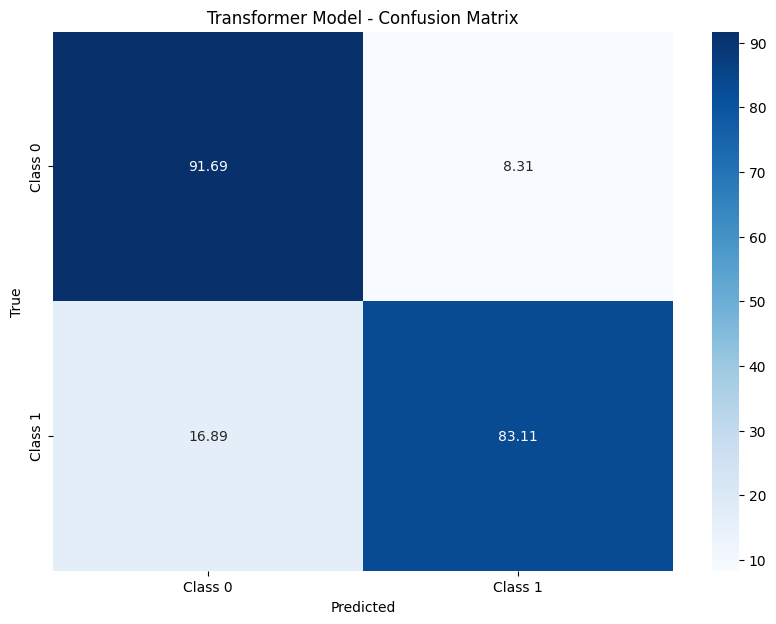

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt
import os

# تعریف مدل ترنسفورمر مشابه مدل آموزش‌دیده
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2):
        super(TransformerModel, self).__init__()
        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=input_dim, num_heads=num_heads) for _ in range(num_layers)
        ])
        self.layer_norm = nn.LayerNorm(input_dim)
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            x, _ = attention(x, x, x)
        x = x.transpose(0, 1)  # بازگشت به شکل اولیه
        x = self.layer_norm(x)
        x = torch.mean(x, dim=1)  # GlobalAveragePooling
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)       # اعمال Dropout
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

# تعریف دیتاست تست
class CustomTestDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.data[idx], dtype=torch.float32)

# بارگذاری داده‌های تست
def load_test_data_as_dataloader(file_paths, labels=None, batch_size=32):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)
    dataset = CustomTestDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# تابع برای پیش‌بینی با مدل PyTorch
def test_transformer_model(test_loader, model_load_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    input_dim = 1024  # ابعاد ورودی داده‌ها
    num_classes = 2   # تعداد کلاس‌ها
    model = TransformerModel(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    # بارگذاری وزن‌های مدل
    model.load_state_dict(torch.load(model_load_path, map_location=device))
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy()[:, 1])  # استخراج احتمال برچسب مثبت

    all_probs = np.array(all_probs)
    return np.array(all_labels), np.array(all_predictions), all_probs

# مسیر فایل‌های تست
test_save_paths_X = [
    '/content/drive/MyDrive/resized_X_TEST.npy'
]

# بارگذاری برچسب‌های تست
y_test = np.array(np.loadtxt('/content/drive/MyDrive/y_test_final.csv', delimiter=',', dtype=int))

# آماده‌سازی داده‌ها به عنوان DataLoader برای تست
test_loader = load_test_data_as_dataloader(test_save_paths_X, labels=y_test, batch_size=32)

# مسیر مدل ذخیره شده
model_load_path = '/content/drive/MyDrive/transformer_model_final1.pth'

# تست مدل
y_true, y_pred_labels, predicted_probs = test_transformer_model(test_loader, model_load_path)

# محاسبه و نمایش معیارهای عملکرد
def calculate_metrics(y_true, y_pred_labels, y_pred_probs):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    accuracy = accuracy_score(y_true, y_pred_labels) * 100
    f1 = f1_score(y_true, y_pred_labels) * 100
    mcc = matthews_corrcoef(y_true, y_pred_labels) * 100
    auroc = roc_auc_score(y_true, y_pred_probs) * 100
    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")
    print(f"auROC:           {auroc:.2f}%")

calculate_metrics(y_true, y_pred_labels, predicted_probs)

# نمایش ماتریس اختلاط و ذخیره تصویر
def display_conf_matrix(y_true, y_pred_labels, title, filename):
    cm = confusion_matrix(y_true, y_pred_labels)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # تبدیل به درصد
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

# ایجاد دایرکتوری Figures در صورت عدم وجود
output_dir = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/Figuresfinal'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# نمایش ماتریس اختلاط و ذخیره تصویر
output_file = os.path.join(output_dir, 'Transformer_Model_CM.png')
display_conf_matrix(y_true, y_pred_labels, 'Transformer Model - Confusion Matrix', output_file)


<ipython-input-16-715db91b81e7>:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path))


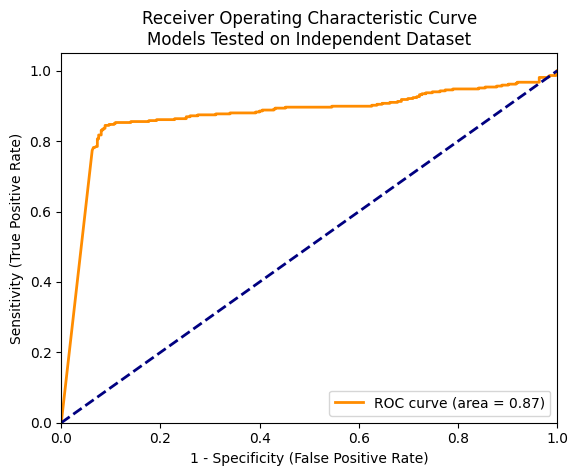

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import os

# تعریف مدل ترنسفورمر مشابه مدل آموزش‌دیده
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2):
        super(TransformerModel, self).__init__()
        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=input_dim, num_heads=num_heads) for _ in range(num_layers)
        ])
        self.layer_norm = nn.LayerNorm(input_dim)
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            x, _ = attention(x, x, x)
        x = x.transpose(0, 1)  # بازگشت به شکل اولیه
        x = self.layer_norm(x)
        x = torch.mean(x, dim=1)  # GlobalAveragePooling
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)       # اعمال Dropout
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

# تعریف دیتاست تست
class CustomTestDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.data[idx], dtype=torch.float32)

# بارگذاری داده‌های تست
def load_test_data_as_dataloader(file_paths, labels=None, batch_size=32):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)
    dataset = CustomTestDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# تابع برای پیش‌بینی با مدل PyTorch
def test_transformer_model(test_loader, model_load_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ایجاد مدل و انتقال به GPU
    input_dim = 1024  # ابعاد ورودی داده‌ها
    num_classes = 2   # تعداد کلاس‌ها
    model = TransformerModel(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    # بارگذاری وزن‌های مدل
    model.load_state_dict(torch.load(model_load_path))
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            probs = outputs.cpu().numpy()
            predicted = np.argmax(probs, axis=1)
            all_predictions.extend(predicted)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)

    return np.array(all_labels), np.array(all_predictions), np.array(all_probs)

# مسیر فایل‌های تست
test_save_paths_X = [
    '/content/drive/MyDrive/resized_X_TEST.npy'
]

# بارگذاری برچسب‌های تست
y_test = np.array(np.loadtxt('/content/drive/MyDrive/y_test_final.csv', delimiter=',', dtype=int))

# آماده‌سازی داده‌ها به عنوان DataLoader برای تست
test_loader = load_test_data_as_dataloader(test_save_paths_X, labels=y_test, batch_size=32)

# مسیر مدل ذخیره شده
model_load_path = '/content/drive/MyDrive/transformer_model_final1.pth'

# تست مدل
y_true, y_pred_labels, y_pred_probs = test_transformer_model(test_loader, model_load_path)

# محاسبه و رسم منحنی ROC
def plot_roc_curve(y_true, y_pred_probs):
    # محاسبه منحنی ROC
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity (False Positive Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('Receiver Operating Characteristic Curve\nModels Tested on Independent Dataset')
    plt.legend(loc="lower right")
    plt.show()

# رسم منحنی ROC
plot_roc_curve(y_true, y_pred_probs)


In [ ]:
DS1 TEST

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


<ipython-input-2-35641859f223>:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_location=device))


Sensitivity:     86.65%
Specificity:     91.17%
Accuracy:        88.96%
F1 Score:        88.46%
MCC:             77.95%
auROC:           92.16%


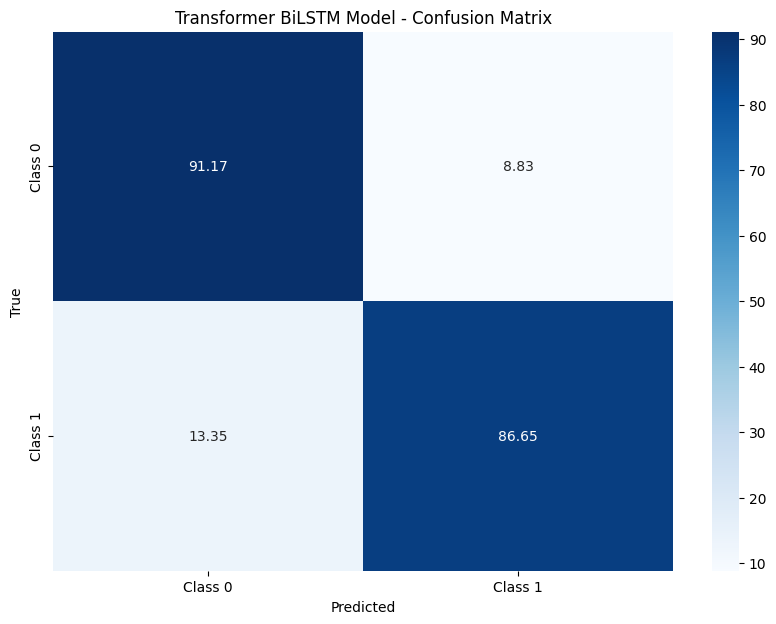

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt
import os

# تعریف مدل مشابه مدل آموزشی با BiLSTM
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=32):
        super(TransformerWithBiLSTM, self).__init__()

        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        lstm_out, _ = self.bilstm(x)
        lstm_out = lstm_out.transpose(0, 1)
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)
        lstm_out = torch.softmax(self.fc2(lstm_out), dim=-1)
        return lstm_out

# تابع برای بارگذاری داده‌های تست
class CustomTestDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.data[idx], dtype=torch.float32)

def load_test_data_as_dataloader(file_paths, labels=None, batch_size=32):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)
    dataset = CustomTestDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# تابع تست مدل
def test_transformer_model(test_loader, model_load_path, input_dim=1024, num_classes=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    # بارگذاری مدل ذخیره‌شده
    model.load_state_dict(torch.load(model_load_path, map_location=device))
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy()[:, 1])  # احتمال برچسب مثبت

    all_probs = np.array(all_probs)
    return np.array(all_labels), np.array(all_predictions), all_probs

# محاسبه و نمایش معیارهای عملکرد
def calculate_metrics(y_true, y_pred_labels, y_pred_probs):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    accuracy = accuracy_score(y_true, y_pred_labels) * 100
    f1 = f1_score(y_true, y_pred_labels) * 100
    mcc = matthews_corrcoef(y_true, y_pred_labels) * 100
    auroc = roc_auc_score(y_true, y_pred_probs) * 100
    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")
    print(f"auROC:           {auroc:.2f}%")

# نمایش ماتریس اختلاط درصدی و ذخیره تصویر
def display_conf_matrix(y_true, y_pred_labels, title, filename):
    cm = confusion_matrix(y_true, y_pred_labels)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

# تست مدل با استفاده از داده‌های تست
test_save_paths_X = ['/content/drive/MyDrive/resized_X_TEST.npy']
y_test = np.loadtxt('/content/drive/MyDrive/y_test_final.csv', delimiter=',', dtype=int)

test_loader = load_test_data_as_dataloader(test_save_paths_X, labels=y_test, batch_size=32)
model_load_path = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/transformer_bilstm2_model.pth'

y_true, y_pred_labels, predicted_probs = test_transformer_model(test_loader, model_load_path)

# محاسبه معیارها
calculate_metrics(y_true, y_pred_labels, predicted_probs)

# نمایش ماتریس کانفیوژن
output_dir = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/Figuresfinal'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

output_file = os.path.join(output_dir, 'Transformer_BiLSTM_Model_CM.png')
display_conf_matrix(y_true, y_pred_labels, 'Transformer BiLSTM Model - Confusion Matrix', output_file)


<ipython-input-8-4aa674e02529>:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_location=device))


Sensitivity:     86.65%
Specificity:     91.17%
Accuracy:        88.96%
F1 Score:        88.46%
MCC:             77.95%
auROC:           92.16%


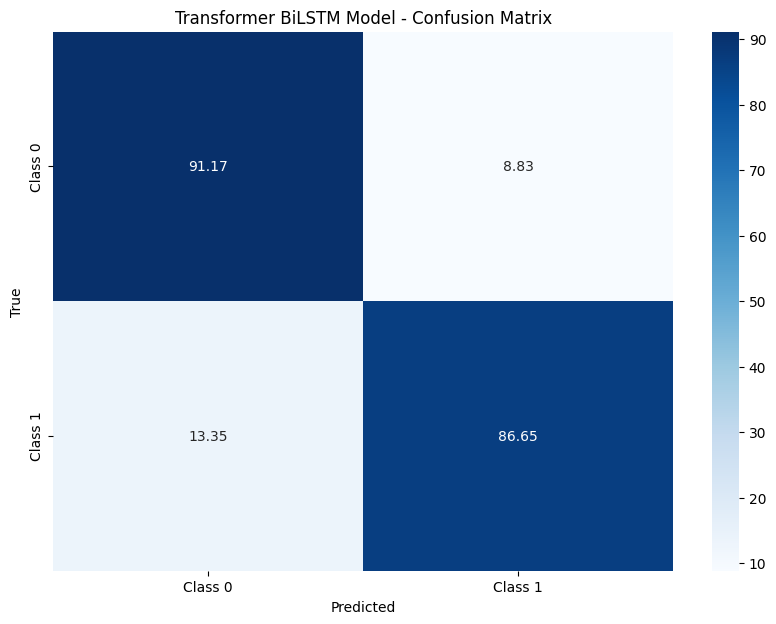

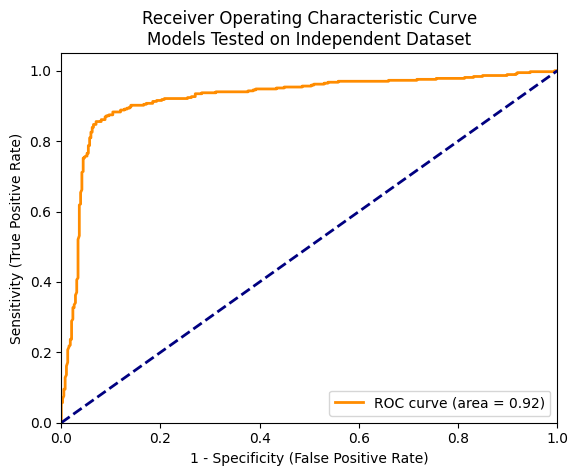

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import os

# تعریف مدل مشابه مدل آموزشی با BiLSTM
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=32):
        super(TransformerWithBiLSTM, self).__init__()

        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        lstm_out, _ = self.bilstm(x)
        lstm_out = lstm_out.transpose(0, 1)
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)
        lstm_out = torch.softmax(self.fc2(lstm_out), dim=-1)
        return lstm_out

# تابع برای بارگذاری داده‌های تست
class CustomTestDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.data[idx], dtype=torch.float32)

def load_test_data_as_dataloader(file_paths, labels=None, batch_size=32):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)
    dataset = CustomTestDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# تابع تست مدل
def test_transformer_model(test_loader, model_load_path, input_dim=1024, num_classes=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    # بارگذاری مدل ذخیره‌شده
    model.load_state_dict(torch.load(model_load_path, map_location=device))
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())  # تمامی احتمال‌ها (برای هر دو کلاس)

    all_probs = np.array(all_probs)
    return np.array(all_labels), np.array(all_predictions), all_probs

# محاسبه و نمایش معیارهای عملکرد
def calculate_metrics(y_true, y_pred_labels, y_pred_probs):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    accuracy = accuracy_score(y_true, y_pred_labels) * 100
    f1 = f1_score(y_true, y_pred_labels) * 100
    mcc = matthews_corrcoef(y_true, y_pred_labels) * 100
    auroc = roc_auc_score(y_true, y_pred_probs[:, 1]) * 100  # استفاده از ستون احتمال مثبت
    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")
    print(f"auROC:           {auroc:.2f}%")

# نمایش ماتریس کانفیوژن درصدی و ذخیره تصویر
def display_conf_matrix(y_true, y_pred_labels, title, filename):
    cm = confusion_matrix(y_true, y_pred_labels)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

# محاسبه و رسم منحنی ROC
def plot_roc_curve(y_true, y_pred_probs):
    # محاسبه منحنی ROC
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity (False Positive Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('Receiver Operating Characteristic Curve\nModels Tested on Independent Dataset')
    plt.legend(loc="lower right")
    plt.show()

# تست مدل با استفاده از داده‌های تست
test_save_paths_X = ['/content/drive/MyDrive/resized_X_TEST.npy']
y_test = np.loadtxt('/content/drive/MyDrive/y_test_final.csv', delimiter=',', dtype=int)

test_loader = load_test_data_as_dataloader(test_save_paths_X, labels=y_test, batch_size=32)
model_load_path = '/content/drive/MyDrive/transformer_bilstm2_model.pth'

y_true, y_pred_labels, predicted_probs = test_transformer_model(test_loader, model_load_path)

# محاسبه معیارها
calculate_metrics(y_true, y_pred_labels, predicted_probs)

# نمایش ماتریس کانفیوژن
output_dir = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/Figuresfinal'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

output_file = os.path.join(output_dir, 'Transformer_BiLSTM_Model_CM.png')
display_conf_matrix(y_true, y_pred_labels, 'Transformer BiLSTM Model - Confusion Matrix', output_file)

# رسم منحنی ROC
plot_roc_curve(y_true, predicted_probs[:, 1])


<ipython-input-3-d02d509208a3>:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_location=device))


Sensitivity:     87.47%
Specificity:     90.39%
Accuracy:        88.96%
F1 Score:        88.55%
MCC:             77.92%
auROC:           93.39%


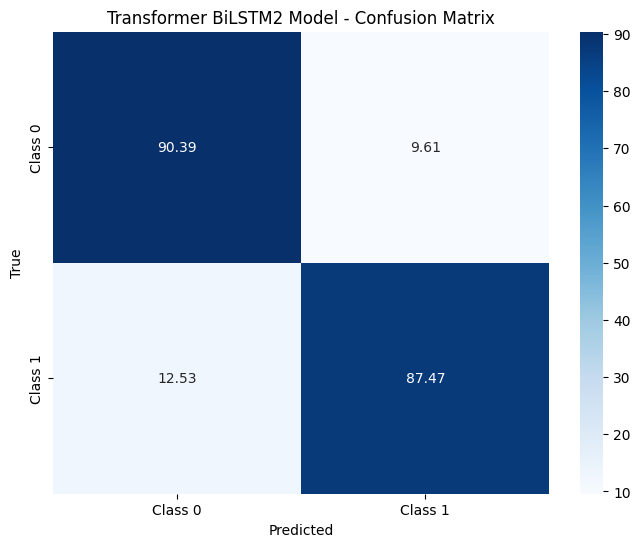

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt
import os

# تعریف مدل مشابه مدل آموزشی با BiLSTM
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=32):
        super(TransformerWithBiLSTM, self).__init__()

        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        lstm_out, _ = self.bilstm(x)
        lstm_out = lstm_out.transpose(0, 1)
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)
        lstm_out = torch.softmax(self.fc2(lstm_out), dim=-1)
        return lstm_out

# تعریف دیتاست سفارشی برای تست
class CustomTestDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.data[idx], dtype=torch.float32)

# تابع برای بارگذاری داده‌های تست به عنوان DataLoader
def load_test_data_as_dataloader(file_paths, labels=None, batch_size=32):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)
    dataset = CustomTestDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# تابع تست مدل
def test_transformer_model(test_loader, model_load_path, input_dim=1024, num_classes=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    # بارگذاری مدل ذخیره‌شده
    model.load_state_dict(torch.load(model_load_path, map_location=device))
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy()[:, 1])  # احتمال برچسب مثبت

    all_probs = np.array(all_probs)
    return np.array(all_labels), np.array(all_predictions), all_probs

# محاسبه و نمایش معیارهای عملکرد
def calculate_metrics(y_true, y_pred_labels, y_pred_probs):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    accuracy = accuracy_score(y_true, y_pred_labels) * 100
    f1 = f1_score(y_true, y_pred_labels) * 100
    mcc = matthews_corrcoef(y_true, y_pred_labels) * 100
    auroc = roc_auc_score(y_true, y_pred_probs) * 100
    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")
    print(f"auROC:           {auroc:.2f}%")

# نمایش ماتریس کانفیوژن درصدی و ذخیره تصویر
def display_conf_matrix(y_true, y_pred_labels, title, filename):
    cm = confusion_matrix(y_true, y_pred_labels)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

# مسیر فایل‌های تست
test_save_paths_X = ['/content/drive/MyDrive/resized_X_TEST.npy']
test_label_csv_path = '/content/drive/MyDrive/y_test_final.csv'

# بارگذاری برچسب‌های تست
y_test = np.loadtxt(test_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای تست
test_loader = load_test_data_as_dataloader(test_save_paths_X, labels=y_test, batch_size=32)

# مسیر مدل ذخیره شده
model_load_path = '/content/drive/MyDrive/transformer_bilstmrrr_model.pth'

# تست مدل
y_true, y_pred_labels, predicted_probs = test_transformer_model(test_loader, model_load_path)

# محاسبه معیارها
calculate_metrics(y_true, y_pred_labels, predicted_probs)

# ایجاد دایرکتوری برای ذخیره تصاویر در صورت عدم وجود
output_dir = 'C:\\ghorbani\\LMPred_AMP_Prediction-main\\Figuresfinal'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# نمایش و ذخیره ماتریس کانفیوژن
output_file = os.path.join(output_dir, 'Transformer_BiLSTM2_Model_CM.png')
display_conf_matrix(y_true, y_pred_labels, 'Transformer BiLSTM2 Model - Confusion Matrix', output_file)


<ipython-input-2-3ca244763ea6>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_location=device))


Sensitivity:     89.37%
Specificity:     91.43%
Accuracy:        90.43%
F1 Score:        90.11%
MCC:             80.84%
auROC:           94.85%


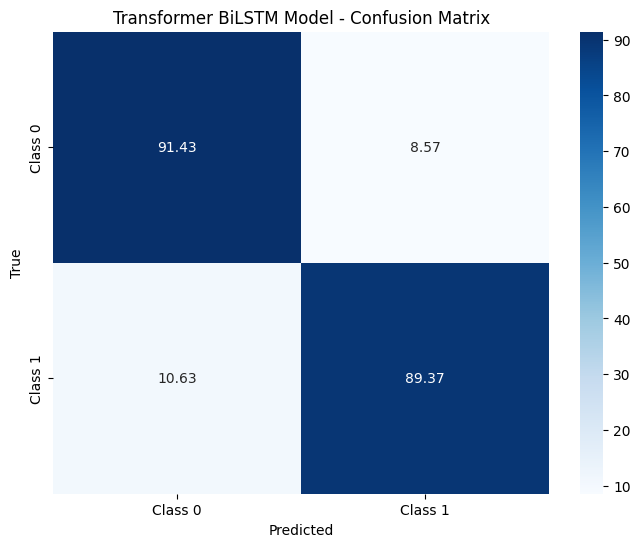

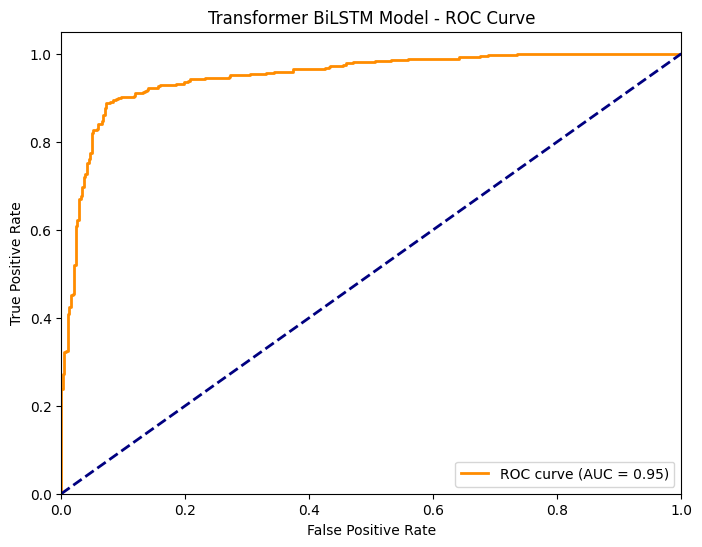

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import os

# تعریف دیتاست سفارشی برای تست
class CustomTestDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labels is not None:
            return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            return torch.tensor(self.data[idx], dtype=torch.float32)

# تابع برای بارگذاری داده‌های تست به عنوان DataLoader
def load_test_data_as_dataloader(file_paths, labels=None, batch_size=32):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)
    dataset = CustomTestDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# مدل ترنسفورمر با BiLSTM برای تست
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه‌های BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)  # کاهش ابعاد لایه خطی
        self.dropout = nn.Dropout(dropout_rate)        # تغییر نرخ Dropout
        self.fc2 = nn.Linear(64, num_classes)          # سازگاری با ابعاد جدید

    def forward(self, x):
        # عبور از لایه BiLSTM
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # برای سازگاری با PyTorch
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # GlobalAveragePooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)       # اعمال Dropout
        lstm_out = torch.softmax(self.fc2(lstm_out), dim=-1)
        return lstm_out

# تابع تست مدل
def test_transformer_model(test_loader, model_load_path, input_dim=1024, num_classes=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    # بارگذاری مدل ذخیره‌شده
    model.load_state_dict(torch.load(model_load_path, map_location=device))
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy()[:, 1])  # احتمال برچسب مثبت

    all_probs = np.array(all_probs)
    return np.array(all_labels), np.array(all_predictions), all_probs

# محاسبه و نمایش معیارهای عملکرد
def calculate_metrics(y_true, y_pred_labels, y_pred_probs):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    accuracy = accuracy_score(y_true, y_pred_labels) * 100
    f1 = f1_score(y_true, y_pred_labels) * 100
    mcc = matthews_corrcoef(y_true, y_pred_labels) * 100
    auroc = roc_auc_score(y_true, y_pred_probs) * 100
    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")
    print(f"auROC:           {auroc:.2f}%")

# نمایش ماتریس کانفیوژن درصدی و ذخیره تصویر
def display_conf_matrix(y_true, y_pred_labels, title, filename):
    cm = confusion_matrix(y_true, y_pred_labels)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

# رسم نمودار ROC
def plot_roc_curve(y_true, y_pred_probs, title, filename):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_true, y_pred_probs):.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.show()

# مسیر فایل‌های تست
test_save_paths_X = ['/content/drive/MyDrive/resized_X_TEST.npy']
test_label_csv_path = '/content/drive/MyDrive/y_test_final.csv'

# بارگذاری برچسب‌های تست
y_test = np.loadtxt(test_label_csv_path, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader برای تست
test_loader = load_test_data_as_dataloader(test_save_paths_X, labels=y_test, batch_size=32)

# مسیر مدل ذخیره شده
model_load_path = '/content/drive/MyDrive/transformer_bilstmbb1_model.pth'

# تست مدل
y_true, y_pred_labels, predicted_probs = test_transformer_model(test_loader, model_load_path)

# محاسبه معیارها
calculate_metrics(y_true, y_pred_labels, predicted_probs)

# ایجاد دایرکتوری برای ذخیره تصاویر در صورت عدم وجود
output_dir = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/Figuresfinal'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# نمایش و ذخیره ماتریس کانفیوژن
output_file_cm = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_CM.png')
display_conf_matrix(y_true, y_pred_labels, 'Transformer BiLSTM Model - Confusion Matrix', output_file_cm)

# نمایش و ذخیره نمودار ROC
output_file_roc = os.path.join(output_dir, 'Transformer_BiLSTM3_Model_ROC.png')
plot_roc_curve(y_true, predicted_probs, 'Transformer BiLSTM Model - ROC Curve', output_file_roc)




"In the following codes, Peer Learning (unsupervised learning) testing is performed on the first dataset(DS1)

In [ ]:
pu learning(DS1)

<ipython-input-12-040680b80540>:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))  # Load the model weights


Test Loss: 0.4215, Test Accuracy: 89.06%
Sensitivity:     95.38%
Specificity:     82.74%
Accuracy:        89.06%
F1 Score:        89.71%
MCC:             78.75%
auROC:           90.40%


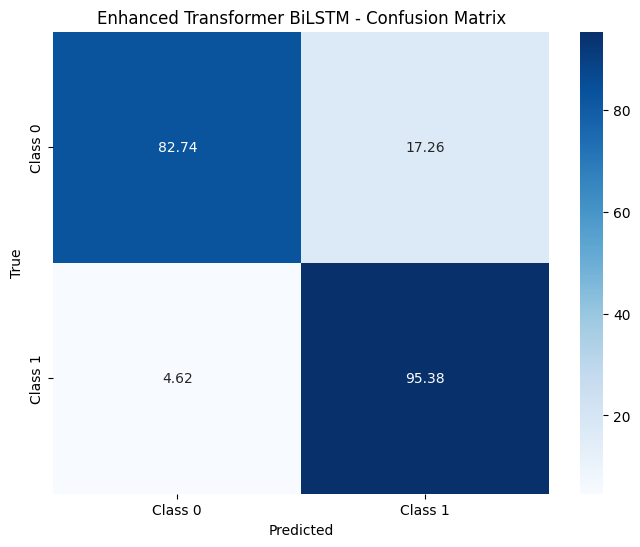

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt

# Custom Dataset Definition
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# Function to load data as DataLoader
def load_data_as_dataloader(data_path, labels_path, batch_size):
    data = np.load(data_path, mmap_mode='r')
    labels = np.loadtxt(labels_path, delimiter=',', converters={0: lambda x: int(float(x))}, dtype=int)

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)  # No shuffling for test data
    return dataloader

# Transformer model with enhanced BiLSTM layers in PyTorch
class EnhancedTransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=4, num_layers=2, lstm_hidden_dim=128):
        super(EnhancedTransformerWithBiLSTM, self).__init__()

        # BiLSTM layers
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 128)
        self.dropout = nn.Dropout(0.2)  # Reduce Dropout
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        lstm_out, _ = self.bilstm(x)

        lstm_out = lstm_out.transpose(0, 1)
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = torch.relu(self.fc1(lstm_out))

        lstm_out = self.dropout(lstm_out)
        lstm_out = torch.softmax(self.fc2(lstm_out), dim=-1)
        return lstm_out

# Model testing function
def test_transformer_model(test_loader, model_path, input_dim, num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = EnhancedTransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.load_state_dict(torch.load(model_path))  # Load the model weights
    model.to(device)
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []
    criterion = nn.CrossEntropyLoss()
    total_test_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for test_X, test_y in test_loader:
            test_X, test_y = test_X.to(device), test_y.to(device)
            outputs = model(test_X)
            loss = criterion(outputs, test_y)
            total_test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += test_y.size(0)
            correct_test += (predicted == test_y).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(test_y.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy()[:, 1])  # Probability of the positive class

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Loss: {total_test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return np.array(all_labels), np.array(all_predictions), np.array(all_probs)

# Compute and display metrics
def calculate_metrics(y_true, y_pred_labels, y_pred_probs):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    accuracy = accuracy_score(y_true, y_pred_labels) * 100
    f1 = f1_score(y_true, y_pred_labels) * 100
    mcc = matthews_corrcoef(y_true, y_pred_labels) * 100
    auroc = roc_auc_score(y_true, y_pred_probs) * 100

    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")
    print(f"auROC:           {auroc:.2f}%")

# Display and save confusion matrix
def display_conf_matrix(y_true, y_pred_labels, title, filename):
    cm = confusion_matrix(y_true, y_pred_labels)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

# File paths for test data
test_data_path = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/resized_X_test_final_2.npy'
test_labels_path = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/y_test_final_2.csv'

# Prepare data as DataLoader for testing
test_loader = load_data_as_dataloader(test_data_path, test_labels_path, batch_size=32)

# Testing the model
input_dim = 1024
num_classes = 2

y_true, y_pred_labels, predicted_probs = test_transformer_model(
    test_loader,
    model_path='/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/enhanced_transformer_bilstm114_model.pth',
    input_dim=input_dim,
    num_classes=num_classes
)

# Calculate metrics
calculate_metrics(y_true, y_pred_labels, predicted_probs)

# Create directory for saving figures if it doesn't exist
output_dir = 'content/drive/MyDrive/my_project/LMPred_AMP_Prediction/Figuresfinal'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Display and save confusion matrix
output_file = os.path.join(output_dir, 'Enhanced_Transformer_BiLSTM_Confusion_Matrix.png')
display_conf_matrix(y_true, y_pred_labels, 'Enhanced Transformer BiLSTM - Confusion Matrix', output_file)


<ipython-input-2-f0bbd7dbf968>:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Test Loss: 0.4215, Test Accuracy: 89.06%
Sensitivity:     95.38%
Specificity:     82.74%
Accuracy:        89.06%
F1 Score:        89.71%
MCC:             78.75%
auROC:           90.40%


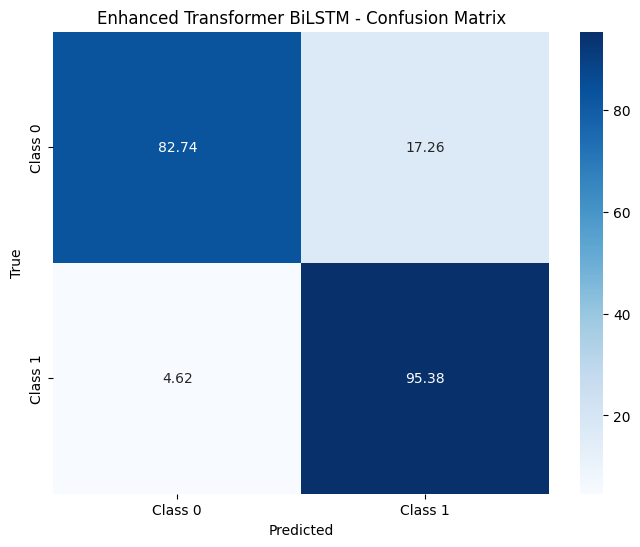

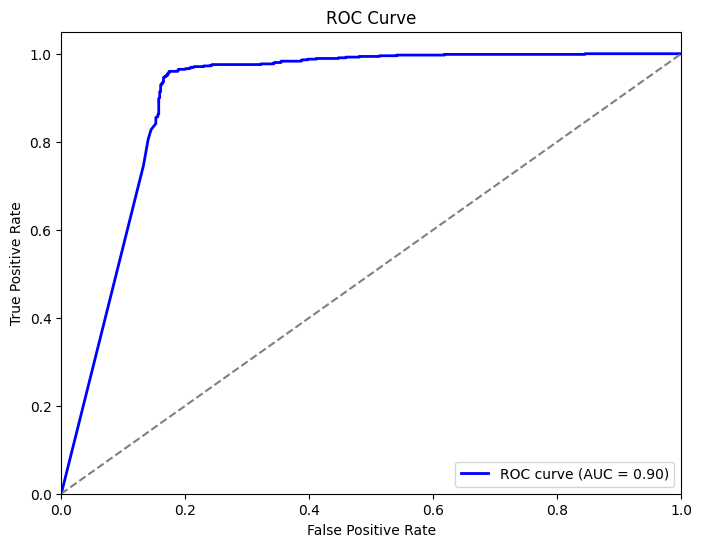

In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import (confusion_matrix, accuracy_score, f1_score,
                             roc_auc_score, matthews_corrcoef, roc_curve)
import seaborn as sns
import matplotlib.pyplot as plt

# Custom Dataset Definition
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# Function to load data as DataLoader
def load_data_as_dataloader(data_path, labels_path, batch_size):
    data = np.load(data_path, mmap_mode='r')
    labels = np.loadtxt(labels_path, delimiter=',', converters={0: lambda x: int(float(x))}, dtype=int)

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)  # No shuffling for test data
    return dataloader

# Transformer model with enhanced BiLSTM layers in PyTorch
class EnhancedTransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=4, num_layers=2, lstm_hidden_dim=128):
        super(EnhancedTransformerWithBiLSTM, self).__init__()

        # BiLSTM layers
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 128)
        self.dropout = nn.Dropout(0.2)  # Reduce Dropout
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        lstm_out, _ = self.bilstm(x)

        lstm_out = lstm_out.transpose(0, 1)
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = torch.relu(self.fc1(lstm_out))

        lstm_out = self.dropout(lstm_out)
        lstm_out = torch.softmax(self.fc2(lstm_out), dim=-1)
        return lstm_out

# Model testing function
def test_transformer_model(test_loader, model_path, input_dim, num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = EnhancedTransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)

    # Load the model weights, and map to 'cpu' if CUDA is not available
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []
    criterion = nn.CrossEntropyLoss()
    total_test_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for test_X, test_y in test_loader:
            test_X, test_y = test_X.to(device), test_y.to(device)
            outputs = model(test_X)
            loss = criterion(outputs, test_y)
            total_test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += test_y.size(0)
            correct_test += (predicted == test_y).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(test_y.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy()[:, 1])  # Probability of the positive class

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Loss: {total_test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return np.array(all_labels), np.array(all_predictions), np.array(all_probs)

# Compute and display metrics
def calculate_metrics(y_true, y_pred_labels, y_pred_probs):
    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    accuracy = accuracy_score(y_true, y_pred_labels) * 100
    f1 = f1_score(y_true, y_pred_labels) * 100
    mcc = matthews_corrcoef(y_true, y_pred_labels) * 100
    auroc = roc_auc_score(y_true, y_pred_probs) * 100

    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")
    print(f"auROC:           {auroc:.2f}%")

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_probs, filename):
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    auc_score = roc_auc_score(y_true, y_pred_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.show()

# Display and save confusion matrix
def display_conf_matrix(y_true, y_pred_labels, title, filename):
    cm = confusion_matrix(y_true, y_pred_labels)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    plt.show()

# File paths for test data
test_data_path = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/resized_X_test_final_2.npy'
test_labels_path = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/y_test_final_2.csv'

# Prepare data as DataLoader for testing
test_loader = load_data_as_dataloader(test_data_path, test_labels_path, batch_size=32)

# Testing the model
input_dim = 1024
num_classes = 2

y_true, y_pred_labels, predicted_probs = test_transformer_model(
    test_loader,
    model_path='/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/enhanced_transformer_bilstm114_model.pth',
    input_dim=input_dim,
    num_classes=num_classes
)

# Calculate metrics
calculate_metrics(y_true, y_pred_labels, predicted_probs)

# Create directory for saving figures if it doesn't exist
output_dir = 'content/drive/MyDrive/my_project/LMPred_AMP_Prediction/Figuresfinal'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Display and save confusion matrix
output_file_cm = os.path.join(output_dir, 'Enhanced_Transformer_BiLSTM_Confusion_Matrix.png')
display_conf_matrix(y_true, y_pred_labels, 'Enhanced Transformer BiLSTM - Confusion Matrix', output_file_cm)

# Plot and save ROC curve
output_file_roc = os.path.join(output_dir, 'Enhanced_Transformer_BiLSTM_ROC_Curve.png')
plot_roc_curve(y_true, predicted_probs, output_file_roc)


<ipython-input-44-e02c3798de9f>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Sensitivity (Recall): 95.84%
Specificity: 83.98%
Accuracy: 89.91%
F1 Score: 90.47%
MCC: 80.38%
AUROC: 89.91%


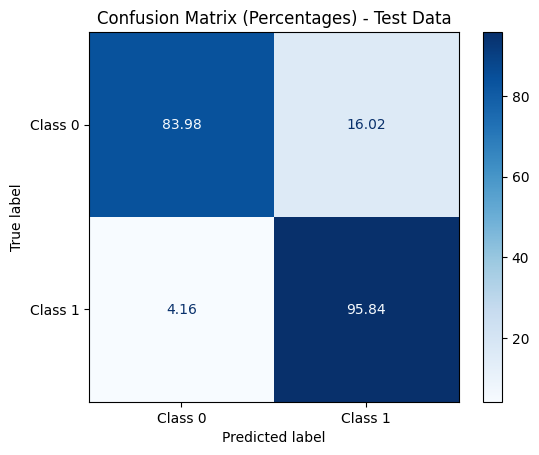

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, roc_auc_score, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support

# Function to calculate sensitivity and specificity
def calculate_sensitivity_specificity(conf_matrix):
    TN, FP, FN, TP = conf_matrix.ravel()

    # Sensitivity (Recall for positive class)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0

    # Specificity (Recall for negative class)
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    return sensitivity, specificity

# Function to evaluate model on test data
def evaluate_transformer_model(test_loader, input_dim, num_classes, model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the saved model
    model = EnhancedTransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    y_true_test = []
    y_pred_test = []

    # Run model on test data
    with torch.no_grad():
        for test_X, test_y in test_loader:
            test_X, test_y = test_X.to(device), test_y.to(device)
            outputs = model(test_X)
            _, predicted = torch.max(outputs.data, 1)
            y_true_test.extend(test_y.cpu().numpy())
            y_pred_test.extend(predicted.cpu().numpy())

    # Calculate confusion matrix
    test_conf_matrix = confusion_matrix(y_true_test, y_pred_test)

    # Calculate metrics
    test_accuracy = accuracy_score(y_true_test, y_pred_test)
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_true_test, y_pred_test, average='binary')
    test_mcc = matthews_corrcoef(y_true_test, y_pred_test)

    try:
        test_auroc = roc_auc_score(y_true_test, y_pred_test)
    except ValueError:
        test_auroc = None

    # Calculate sensitivity and specificity
    sensitivity, specificity = calculate_sensitivity_specificity(test_conf_matrix)

    # Convert metrics to percentage
    test_accuracy_percent = test_accuracy * 100
    test_precision_percent = test_precision * 100
    sensitivity_percent = sensitivity * 100
    specificity_percent = specificity * 100
    test_f1_percent = test_f1 * 100
    test_mcc_percent = test_mcc * 100
    test_auroc_percent = test_auroc * 100 if test_auroc is not None else None

    # Print metrics
    print(f"Sensitivity (Recall): {sensitivity_percent:.2f}%")
    print(f"Specificity: {specificity_percent:.2f}%")
    print(f"Accuracy: {test_accuracy_percent:.2f}%")
    print(f"F1 Score: {test_f1_percent:.2f}%")
    print(f"MCC: {test_mcc_percent:.2f}%")
    print(f"AUROC: {test_auroc_percent:.2f}%" if test_auroc_percent is not None else "AUROC cannot be calculated.")

    # Plot confusion matrix with percentages
    conf_matrix_percent = test_conf_matrix.astype('float') / test_conf_matrix.sum(axis=1)[:, np.newaxis] * 100
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percent, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap=plt.cm.Blues, values_format='.2f')
    plt.title('Confusion Matrix (Percentages) - Test Data')
    plt.show()

# File paths for test data
test_data_path = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/resized_X_test_final_2.npy'
test_labels_path = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/y_test_final_2.csv'

# Prepare test data as DataLoader
test_loader = load_data_as_dataloader(test_data_path, test_labels_path, batch_size=32, percentage=1.0)

# Evaluate the model on the test data
evaluate_transformer_model(
    test_loader=test_loader,
    input_dim=1024,  # Same input dimension as in training
    num_classes=2,   # Same number of classes
    model_path='/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/enhanced_transformer_bilstm12_model.pth'  # Path to the saved model
)


Test Loss: 0.4133
Sensitivity: 95.84%
Specificity: 83.98%
Accuracy: 89.91%
F1 Score: 90.47%
MCC: 80.38%
auROC: 90.76%


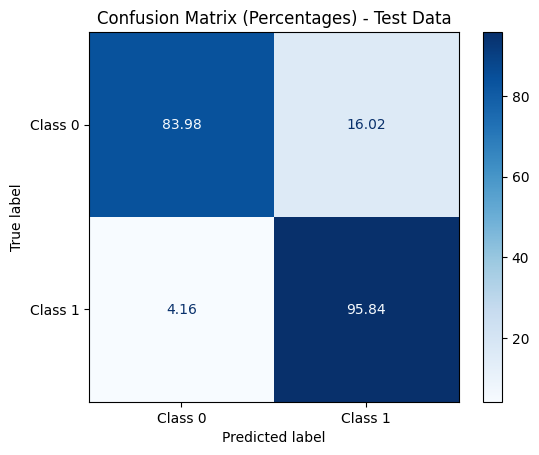

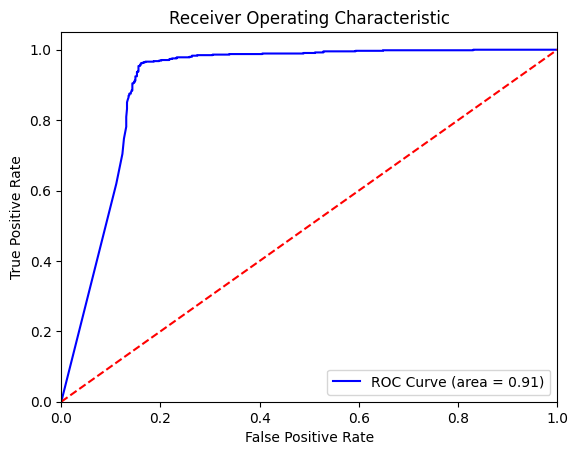

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, roc_curve, ConfusionMatrixDisplay

# Custom Dataset Definition
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# Function to load the test data as DataLoader
def load_test_data_as_dataloader(data_path, labels_path, batch_size):
    data = np.load(data_path, mmap_mode='r')
    labels = np.loadtxt(labels_path, delimiter=',', converters={0: lambda x: int(float(x))}, dtype=int)

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# Transformer model with enhanced BiLSTM layers in PyTorch
class EnhancedTransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=128):
        super(EnhancedTransformerWithBiLSTM, self).__init__()

        # BiLSTM layers
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=1, batch_first=True, bidirectional=True)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        lstm_out, _ = self.bilstm(x)

        lstm_out = lstm_out.transpose(0, 1)
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)
        lstm_out = torch.softmax(self.fc2(lstm_out), dim=-1)
        return lstm_out

# Testing function
def test_transformer_model(test_loader, input_dim, num_classes, model_load_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the model
    model = EnhancedTransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes)
    model.to(device)

    # Load the trained model's state dict
    model.load_state_dict(torch.load(model_load_path, map_location=device, weights_only=True))
    model.eval()  # Set the model to evaluation mode

    all_labels = []
    all_predictions = []
    all_probabilities = []  # برای ذخیره‌سازی احتمال‌ها
    total_test_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for test_X, test_y in test_loader:
            test_X, test_y = test_X.to(device), test_y.to(device)
            outputs = model(test_X)
            loss = criterion(outputs, test_y)
            total_test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(test_y.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(outputs.cpu().numpy())  # ذخیره احتمالات برای auROC

    average_test_loss = total_test_loss / len(test_loader)

    # Calculate metrics
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probabilities = np.array(all_probabilities)

    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(all_labels, all_predictions).ravel()

    # Sensitivity (Recall)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Specificity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Accuracy
    accuracy = accuracy_score(all_labels, all_predictions)

    # F1 Score
    f1 = f1_score(all_labels, all_predictions, average='binary')

    # Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(all_labels, all_predictions)

    # Area Under the Receiver Operating Characteristic (auROC)
    if num_classes == 2:
        auroc = roc_auc_score(all_labels, all_probabilities[:, 1])  # استفاده از احتمال کلاس مثبت
        fpr, tpr, _ = roc_curve(all_labels, all_probabilities[:, 1])  # محاسبه fpr و tpr
    else:
        auroc = None
        fpr, tpr = None, None

    # Print results
    print(f"Test Loss: {average_test_loss:.4f}")
    print(f"Sensitivity: {sensitivity * 100:.2f}%")
    print(f"Specificity: {specificity * 100:.2f}%")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")
    print(f"MCC: {mcc * 100:.2f}%")
    print(f"auROC: {auroc * 100:.2f}%" if auroc is not None else "auROC: N/A")

    # Plot confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percent, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap=plt.cm.Blues, values_format='.2f')
    plt.title('Confusion Matrix (Percentages) - Test Data')
    plt.show()

    # Plot ROC Curve
    if auroc is not None:
        plt.figure()
        plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {auroc:.2f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        plt.show()

# File paths for the test dataset
test_data_path = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/resized_X_test_final_2.npy'
test_labels_path = '/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/y_test_final_2.csv'

# Prepare test data as DataLoader
test_loader = load_test_data_as_dataloader(test_data_path, test_labels_path, batch_size=32)

# Model settings
input_dim = 1024
num_classes = 2

# Testing the model
test_transformer_model(
    test_loader,
    input_dim=input_dim,
    num_classes=num_classes,
    model_load_path='/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/enhanced_transformer_bilstm12_model.pth'
)




All the above code corresponds to the first dataset. Notably, the final results achieved on this dataset were the highest among all, which is why they are presented both in the corresponding code section and in the paper. From this point onward, the model is evaluated on datasets two through six.

In [ ]:
DS2 TEST

<ipython-input-6-704d2b6f390f>:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Accuracy: 0.9743
F1 Score: 0.9743
Sensitivity (Recall): 0.9714
Specificity: 0.9771
MCC: 0.9486
AUROC: 0.9889


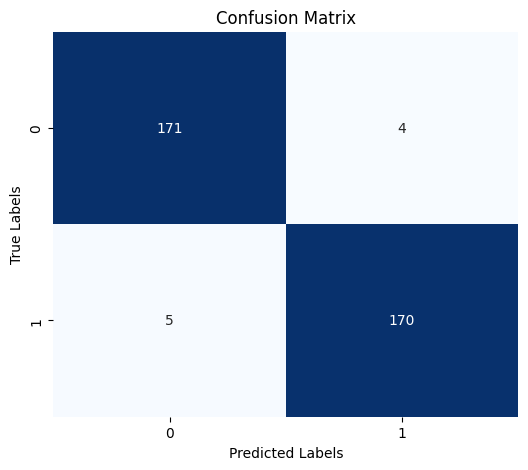

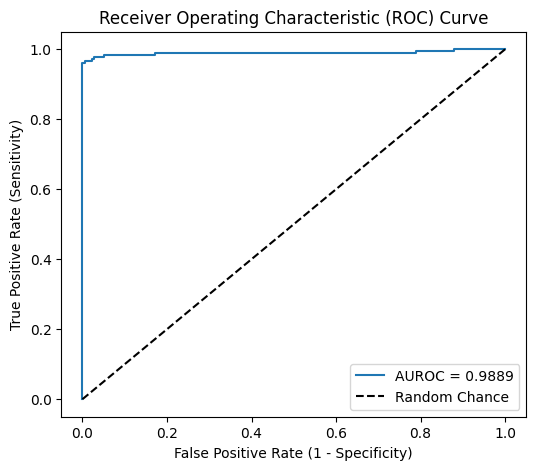

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

# تعریف دیتاست سفارشی
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# مدل ترنسفورمر با لایه‌های BiLSTM در PyTorch
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=64):
        super(TransformerWithBiLSTM, self).__init__()

        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=2, batch_first=True, bidirectional=True)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        lstm_out, _ = self.bilstm(x)
        lstm_out = lstm_out.transpose(0, 1)
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)
        lstm_out = lstm_out.transpose(0, 1)
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)
        lstm_out = torch.softmax(self.fc2(lstm_out), dim=-1)
        return lstm_out

# تابع برای بارگذاری داده‌ها به عنوان DataLoader
def load_data_as_dataloader(file_paths, labels, batch_size, percentage=1.0):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path))
    data = np.concatenate(data, axis=0)

    num_samples = data.shape[0]
    subset_size = int(num_samples * percentage)
    data = data[:subset_size]
    labels = labels[:subset_size]

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# تابع ارزیابی مدل روی داده‌های تست
def evaluate_model_on_test(test_loader, model, num_classes, model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            outputs = model(batch_X)
            probs = outputs.cpu().numpy()
            preds = np.argmax(probs, axis=1)

            all_labels.extend(batch_y.cpu().numpy())
            all_preds.extend(preds)
            all_probs.extend(probs[:, 1])  # احتمالات کلاس مثبت (برای نمودار ROC)

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    mcc = matthews_corrcoef(all_labels, all_preds)
    auroc = roc_auc_score(all_labels, all_probs)

    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"AUROC: {auroc:.4f}")

    # رسم ماتریس کانفیوژن
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # رسم نمودار ROC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUROC = {auroc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

# مسیر داده‌های تست
test_file_paths = [
    '/content/drive/MyDrive/my_project/LMPred_Embeddings/1/resized_X_TEST.npy'  # مسیر فایل‌های تست
]
test_labels = np.loadtxt('/content/drive/MyDrive/my_project/LMPred_Embeddings/1/test_labels_resize.csv', delimiter=',', dtype=int)  # بارگذاری برچسب‌های تست

# آماده‌سازی داده‌های تست به عنوان DataLoader
test_loader = load_data_as_dataloader(test_file_paths, test_labels, batch_size=32, percentage=1.0)

# ارزیابی مدل
evaluate_model_on_test(
    test_loader,
    model=TransformerWithBiLSTM(input_dim=1024, num_classes=2),  # همان مدل تعریف‌شده
    num_classes=2,
    model_path='/content/drive/MyDrive/my_project/LMPred_AMP_Prediction/transformer_bilstmcleap2_model.pth'  # مسیر مدل ذخیره‌شده
)




While the initial test(DS2) accuracy was 97.43%, further training and evaluation on the same dataset led to an improved accuracy of 97.70%.


DS5 TEST

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    classification_report,
    accuracy_score,
    precision_recall_fscore_support,
    matthews_corrcoef
)
from torch.utils.data import DataLoader, Dataset
import seaborn as sns

# تعریف دیتاست سفارشی
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# مدل ترنسفورمر با لایه‌های BiLSTM
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=4, num_layers=3, lstm_hidden_dim=128, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)
        self.attention_layers = nn.ModuleList([nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)])
        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        lstm_out, _ = self.bilstm(x)
        lstm_out = lstm_out.transpose(0, 1)
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)
        lstm_out = lstm_out.transpose(0, 1)
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)
        lstm_out = self.fc2(lstm_out)
        return lstm_out

# تابع برای بارگذاری داده‌های تست
def load_test_data(file_path, labels, batch_size):
    test_data = np.load(file_path)
    test_labels = labels
    test_dataset = CustomDataset(test_data, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader

# تابع برای ارزیابی مدل
def evaluate_model(test_loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []  # ذخیره احتمال‌ها

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            probs = torch.softmax(outputs, dim=1)  # محاسبه احتمال‌ها
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())  # ذخیره احتمال‌ها

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# تابع برای رسم ماتریس سردرگمی
def plot_confusion_matrix(y_true, y_pred, save_path):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.savefig(save_path)  # ذخیره ماتریس سردرگمی
    plt.close()

# تابع برای رسم منحنی ROC
def plot_roc_curve(y_true, y_prob, save_path):
    fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])  # استفاده از احتمال کلاس مثبت
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(roc_auc), linewidth=2)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.savefig(save_path)  # ذخیره منحنی ROC
    plt.close()

# بارگذاری و ارزیابی مدل
def load_and_evaluate_model(test_data_path, test_labels_path, model_path, input_dim, num_classes, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # بارگذاری برچسب‌های تست
    test_labels = np.loadtxt(test_labels_path, delimiter=',', dtype=int, skiprows=1)

    # بارگذاری داده‌های تست
    test_loader = load_test_data(test_data_path, test_labels, batch_size)

    # بارگذاری مدل
    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))

    # ارزیابی
    true_labels, predicted_labels, predicted_probs = evaluate_model(test_loader, model, device)

    # محاسبه معیارها
    accuracy = accuracy_score(true_labels, predicted_labels) * 100
    f1 = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')[2] * 100
    mcc = matthews_corrcoef(true_labels, predicted_labels)
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
    sensitivity = tp / (tp + fn) * 100 if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) * 100 if (tn + fp) > 0 else 0

    # نمایش نتایج
    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")

    # محاسبه و نمایش AUC-ROC
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs[:, 1], pos_label=1)  # استفاده از احتمال کلاس مثبت
    roc_auc = auc(fpr, tpr)
    print(f"AUC-ROC:        {roc_auc:.2f}")

    # رسم ماتریس سردرگمی و منحنی ROC
    confusion_matrix_path = '/content/drive/MyDrive/samptest/confusion1_matrix.png'  # مسیر ذخیره ماتریس سردرگمی
    roc_curve_path = '/content/drive/MyDrive/samptest/roc1_curve.png'  # مسیر ذخیره منحنی ROC
    plot_confusion_matrix(true_labels, predicted_labels, confusion_matrix_path)
    plot_roc_curve(true_labels, predicted_probs, roc_curve_path)

# مسیرها
model_path = '/content/drive/MyDrive/samptest/bilstm1_transformer_model.pth'  # مسیر مدل ذخیره‌شده
test_data_path = '/content/drive/MyDrive/samptest/resized_X_test.npy'  # مسیر داده‌های تست
test_labels_path = '/content/drive/MyDrive/samptest/test_labels.csv'  # مسیر برچسب‌های تست
input_dim = 1024  # تعداد ویژگی‌های ورودی
num_classes = 2  # تعداد کلاس‌ها
batch_size = 32  # اندازه بچ

# ارزیابی مدل
load_and_evaluate_model(test_data_path, test_labels_path, model_path, input_dim, num_classes, batch_size)


<ipython-input-3-2979ffd4fb84>:120: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Sensitivity:     80.75%
Specificity:     80.12%
Accuracy:        80.43%
F1 Score:        80.50%
MCC:             0.61%
AUC-ROC:        0.85


DS(5) FINAL TEST

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    classification_report,
    accuracy_score,
    precision_recall_fscore_support,
    matthews_corrcoef
)
from torch.utils.data import DataLoader, Dataset
import seaborn as sns

# تعریف دیتاست سفارشی
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# مدل ترنسفورمر با لایه‌های BiLSTM
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=4, num_layers=3, lstm_hidden_dim=128, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)
        self.attention_layers = nn.ModuleList([nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)])
        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        lstm_out, _ = self.bilstm(x)
        lstm_out = lstm_out.transpose(0, 1)
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)
        lstm_out = lstm_out.transpose(0, 1)
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)
        lstm_out = self.fc2(lstm_out)
        return lstm_out

# تابع برای بارگذاری داده‌های تست
def load_test_data(file_path, labels, batch_size):
    test_data = np.load(file_path)
    test_labels = labels
    test_dataset = CustomDataset(test_data, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader

# تابع برای ارزیابی مدل
def evaluate_model(test_loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []  # ذخیره احتمال‌ها

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            probs = torch.softmax(outputs, dim=1)  # محاسبه احتمال‌ها
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())  # ذخیره احتمال‌ها

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# تابع برای رسم ماتریس سردرگمی
def plot_confusion_matrix(y_true, y_pred, save_path):
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # درصدی کردن ماتریس
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix (Percentage)')
    plt.savefig(save_path)  # ذخیره ماتریس سردرگمی
    plt.close()

# تابع برای رسم منحنی ROC
def plot_roc_curve(y_true, y_prob, save_path):
    fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])  # استفاده از احتمال کلاس مثبت
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(roc_auc), linewidth=2)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.savefig(save_path)  # ذخیره منحنی ROC
    plt.close()

# بارگذاری و ارزیابی مدل
def load_and_evaluate_model(test_data_path, test_labels_path, model_path, input_dim, num_classes, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # بارگذاری برچسب‌های تست
    test_labels = np.loadtxt(test_labels_path, delimiter=',', dtype=int, skiprows=1)

    # بارگذاری داده‌های تست
    test_loader = load_test_data(test_data_path, test_labels, batch_size)

    # بارگذاری مدل
    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))

    # ارزیابی
    true_labels, predicted_labels, predicted_probs = evaluate_model(test_loader, model, device)

    # محاسبه معیارها
    accuracy = accuracy_score(true_labels, predicted_labels) * 100
    f1 = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')[2] * 100
    mcc = matthews_corrcoef(true_labels, predicted_labels)
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
    sensitivity = tp / (tp + fn) * 100 if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) * 100 if (tn + fp) > 0 else 0

    # نمایش نتایج
    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")  # درصدی

    # محاسبه و نمایش AUC-ROC
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs[:, 1], pos_label=1)  # استفاده از احتمال کلاس مثبت
    roc_auc = auc(fpr, tpr)
    print(f"AUC-ROC:        {roc_auc:.2f}")  # درصدی

    # رسم ماتریس سردرگمی و منحنی ROC
    confusion_matrix_path = '/content/drive/MyDrive/samptest/confusion2_matrix.png'  # مسیر ذخیره ماتریس سردرگمی
    roc_curve_path = '/content/drive/MyDrive/samptest/roc2_curve.png'  # مسیر ذخیره منحنی ROC
    plot_confusion_matrix(true_labels, predicted_labels, confusion_matrix_path)
    plot_roc_curve(true_labels, predicted_probs, roc_curve_path)

# مسیرها
model_path = '/content/drive/MyDrive/samptest/bilstm1_transformer_model.pth'  # مسیر مدل ذخیره‌شده
test_data_path = '/content/drive/MyDrive/samptest/resized_X_test.npy'  # مسیر داده‌های تست
test_labels_path = '/content/drive/MyDrive/samptest/test_labels.csv'  # مسیر برچسب‌های تست
input_dim = 1024  # تعداد ویژگی‌های ورودی
num_classes = 2  # تعداد کلاس‌ها
batch_size = 32  # اندازه بچ

# ارزیابی مدل
load_and_evaluate_model(test_data_path, test_labels_path, model_path, input_dim, num_classes, batch_size)


<ipython-input-4-ef56f66763bd>:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Sensitivity:     80.75%
Specificity:     80.12%
Accuracy:        80.43%
F1 Score:        80.50%
MCC:             0.61%
AUC-ROC:        0.85


<ipython-input-5-62fe9f726805>:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Confusion Matrix:
[[114  47]
 [ 20 141]]
Confusion Matrix (Percentages):
[[70.80745342 29.19254658]
 [12.42236025 87.57763975]]


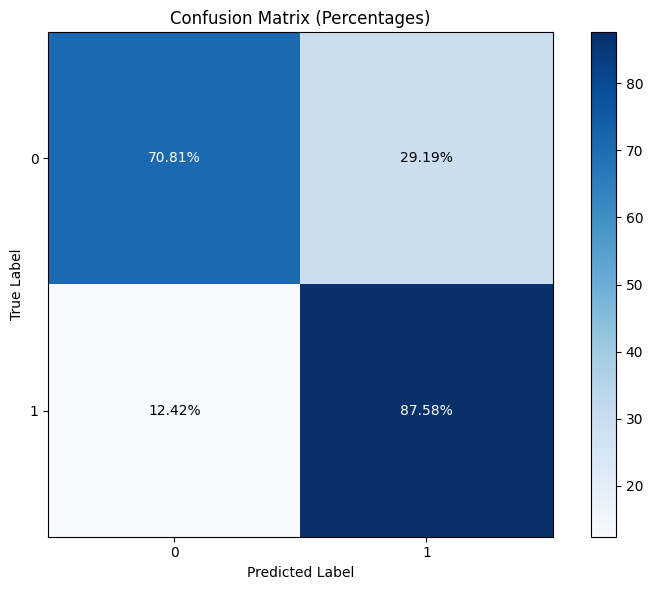

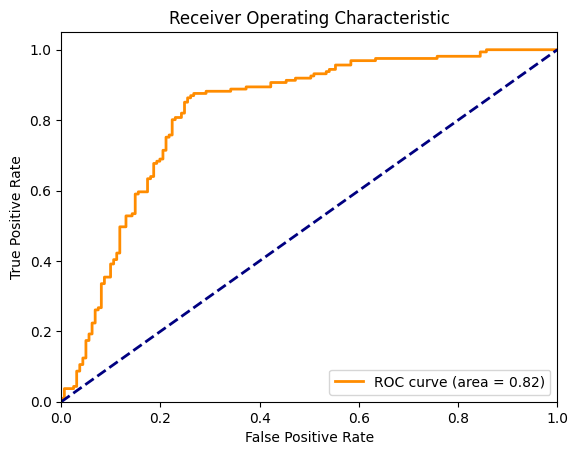

Sensitivity:     87.58%
Specificity:     70.81%
Accuracy:        79.19%
F1 Score:        80.80%
MCC:             0.59%
auROC:           0.82


In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_fscore_support,
    accuracy_score,
    matthews_corrcoef
)
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# Load test data
def load_test_data(file_path, labels, batch_size):
    data = np.load(file_path)
    dataset = CustomDataset(data, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Transformer with BiLSTM model
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=4, num_layers=3, lstm_hidden_dim=128, dropout_rate=0.5):
        super(TransformerWithBiLSTM, self).__init__()
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)
        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])
        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 128)  # Larger dimensions
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, num_classes)  # Final layer

    def forward(self, x):
        lstm_out, _ = self.bilstm(x)
        lstm_out = lstm_out.transpose(0, 1)
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)
        lstm_out = lstm_out.transpose(0, 1)
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)
        lstm_out = self.fc2(lstm_out)
        return lstm_out

# Evaluate the model
def evaluate_model(model, data_loader, device):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            probs = torch.softmax(outputs, dim=1)  # Calculate probabilities
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(batch_y.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())  # Store probabilities

    return all_labels, all_preds, all_probs

# Load and evaluate model
def load_and_evaluate_model(test_data_path, test_labels_path, model_path,
                            cm_save_path, roc_save_path,
                            input_dim, num_classes, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load test labels
    test_labels = np.loadtxt(test_labels_path, delimiter=',', dtype=int, skiprows=1)

    # Load test data
    test_loader = load_test_data(test_data_path, test_labels, batch_size)

    # Load model
    model = TransformerWithBiLSTM(input_dim=input_dim, num_classes=num_classes).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))

    # Evaluation
    all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Calculate percentages for confusion matrix
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Normalize by row
    print("Confusion Matrix (Percentages):")
    print(cm_percentage)

    # Save and display confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm_percentage, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Percentages)')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Annotate with percentages
    thresh = cm_percentage.max() / 2.
    for i, j in np.ndindex(cm_percentage.shape):
        plt.text(j, i, f"{cm_percentage[i, j]:.2f}%", ha="center", va="center",
                 color="white" if cm_percentage[i, j] > thresh else "black")

    plt.tight_layout()
    plt.savefig(cm_save_path)
    plt.show()  # Show the plot

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, [prob[1] for prob in all_probs])  # Use probabilities of the positive class
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig(roc_save_path)
    plt.show()  # Show the plot

    # Calculate evaluation metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = accuracy_score(all_labels, all_preds) * 100
    f1 = precision_recall_fscore_support(all_labels, all_preds, average='binary')[2] * 100
    mcc = matthews_corrcoef(all_labels, all_preds)

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn) * 100 if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) * 100 if (tn + fp) > 0 else 0

    # Display results
    print(f"Sensitivity:     {sensitivity:.2f}%")
    print(f"Specificity:     {specificity:.2f}%")
    print(f"Accuracy:        {accuracy:.2f}%")
    print(f"F1 Score:        {f1:.2f}%")
    print(f"MCC:             {mcc:.2f}%")
    print(f"auROC:           {roc_auc:.2f}")

# Paths
model_path = "/content/drive/MyDrive/samptest/bilstm11_transformer_model.pth"  # Path to saved model
test_data_path = "/content/drive/MyDrive/samptest/resized_X_test.npy"  # Path to test data
test_labels_path = "/content/drive/MyDrive/samptest/test_labels.csv"  # Path to test labels
cm_save_path = "/content/drive/MyDrive/samptest/confusion3_matrix.png"  # Path to save confusion matrix
roc_save_path = "/content/drive/MyDrive/samptest/roc3_curve.png"  # Path to save ROC curve
input_dim = 1024  # Input feature size
num_classes = 2  # Number of classes
batch_size = 32  # Batch size

# Evaluate the model
load_and_evaluate_model(test_data_path, test_labels_path, model_path,
                        cm_save_path, roc_save_path,
                        input_dim, num_classes, batch_size)


In [ ]:
TEST DS(3)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
<ipython-input-6-4464069f6056>:153: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only

Test Accuracy: 71.78%


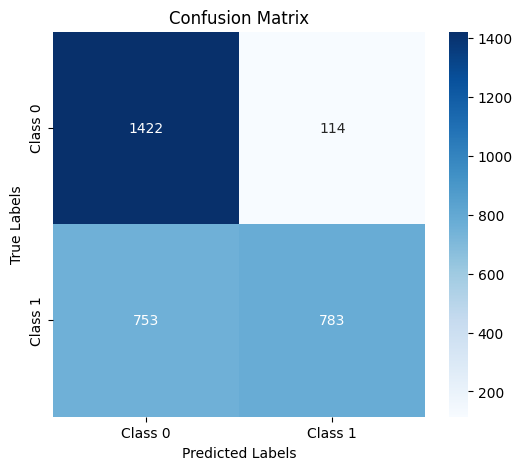

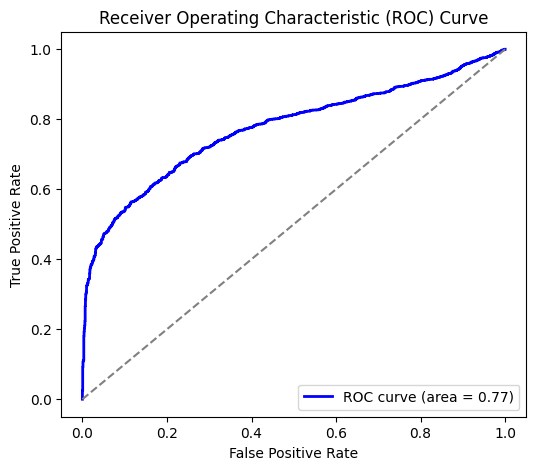

Accuracy: 0.72
Precision: 0.87
Recall: 0.51
F1 Score: 0.64
MCC: 0.48
ROC AUC: 0.77


In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
import seaborn as sns

# تعریف دیتاست سفارشی
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# تابع برای بارگذاری داده‌ها به عنوان DataLoader
def load_data_as_dataloader(data_files, labels, batch_size, percentage=1.0):
    all_data = []
    for file in data_files:
        data = np.load(file)  # بارگذاری داده‌ها از فایل
        all_data.append(data)
    data = np.concatenate(all_data, axis=0)  # ترکیب داده‌های تمام فایل‌ها
    num_samples = data.shape[0]

    # استفاده از درصدی از داده‌ها
    subset_size = int(num_samples * percentage)
    data = data[:subset_size]
    labels = labels[:subset_size]

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# تعریف مدل TransformerWithBiLSTM با معماری جدید
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=4, num_layers=1, lstm_hidden_dim=64, dropout_rate=0.5):
        super(TransformerWithBiLSTM, self).__init__()

        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        lstm_out, _ = self.bilstm(x)
        lstm_out = lstm_out.transpose(0, 1)
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)
        lstm_out = self.fc2(lstm_out)
        return lstm_out

# تابع ارزیابی مدل
def evaluate_model(test_loader, model, device):
    model.eval()
    correct_test = 0
    total_test = 0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for test_X, test_y in test_loader:
            test_X, test_y = test_X.to(device), test_y.to(device)
            outputs = model(test_X)

            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())

            _, predicted = torch.max(outputs.data, 1)
            total_test += test_y.size(0)
            correct_test += (predicted == test_y).sum().item()

            all_labels.extend(test_y.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {accuracy:.2f}%")
    return all_labels, all_predictions, all_probs

# تابع محاسبه و رسم متریک‌ها
def calculate_metrics_and_plot(all_labels, all_predictions, all_probs, model_save_path):
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(f"{model_save_path}_confusion_matrix.png")
    plt.show()

    fpr, tpr, _ = roc_curve(all_labels, [prob[1] for prob in all_probs])
    roc_auc = roc_auc_score(all_labels, [prob[1] for prob in all_probs])

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig(f"{model_save_path}_roc_curve.png")
    plt.show()

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    mcc = matthews_corrcoef(all_labels, all_predictions)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"MCC: {mcc:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")

# فایل‌های ورودی و مسیر مدل
model_save_path = '/content/drive/MyDrive/server15 azar 1/transformer_bilstmunipro03_model.pth'
test_data_files = [
    '/content/drive/MyDrive/my_project/LMPred_Embeddings/NEWUNIPRO/resized_X_TEST_batch_1.npy',
    '/content/drive/MyDrive/my_project/LMPred_Embeddings/NEWUNIPRO/resized_X_TEST_batch_2.npy',
    '/content/drive/MyDrive/my_project/LMPred_Embeddings/NEWUNIPRO/resized_X_TEST_batch_3.npy',
    '/content/drive/MyDrive/my_project/LMPred_Embeddings/NEWUNIPRO/resized_X_TEST_batch_4.npy'
]
test_label_file = '/content/drive/MyDrive/server15 azar 1/updated1_test_labels.csv'

# بارگذاری برچسب‌ها
test_labels = np.loadtxt(test_label_file, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader
test_loader = load_data_as_dataloader(test_data_files, test_labels, batch_size=32, percentage=1.0)

# بارگذاری مدل ذخیره‌شده
model = TransformerWithBiLSTM(input_dim=1024, num_classes=2)
model.load_state_dict(torch.load(model_save_path))

# انتقال مدل به GPU یا CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ارزیابی مدل
all_labels, all_predictions, all_probs = evaluate_model(test_loader, model, device)

# محاسبه و ذخیره نمودارها و متریک‌ها
calculate_metrics_and_plot(all_labels, all_predictions, all_probs, model_save_path)


final unipro(DS3)The dataset used for training included an independent test set, which is used here solely for evaluation. During training, 10-fold cross-validation was applied, and the best-performing model was saved and evaluated on the independent test set. Additionally, I experimented with 20-fold cross-validation, but it did not yield better results.


DS3 FINAL

<ipython-input-5-3b72fb773335>:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


Test Accuracy: 72.98%


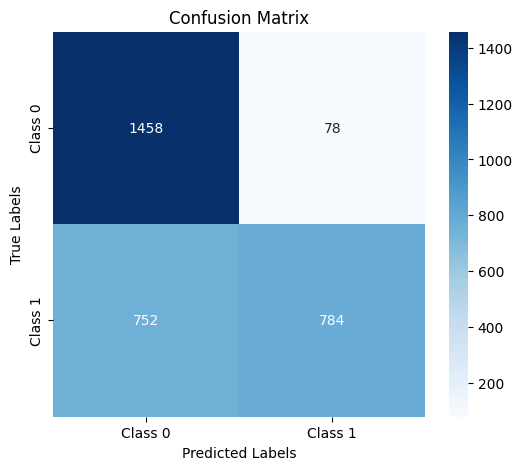

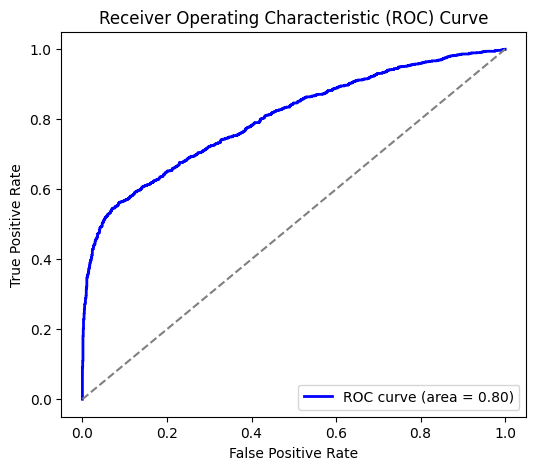

Accuracy: 0.73
Precision: 0.91
Recall: 0.51
F1 Score: 0.65
MCC: 0.51
ROC AUC: 0.80


In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

# تعریف دیتاست سفارشی
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# تابع برای بارگذاری داده‌ها به عنوان DataLoader
def load_data_as_dataloader(data_files, labels, batch_size, percentage=1.0):
    all_data = []
    for file in data_files:
        data = np.load(file)
        all_data.append(data)
    data = np.concatenate(all_data, axis=0)
    num_samples = data.shape[0]

    subset_size = int(num_samples * percentage)
    data = data[:subset_size]
    labels = labels[:subset_size]

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# مدل جدید
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        lstm_out, _ = self.bilstm(x)
        lstm_out = lstm_out.transpose(0, 1)
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)
        lstm_out = self.fc2(lstm_out)
        return lstm_out

# تابع ارزیابی مدل
def evaluate_model(test_loader, model, device):
    model.eval()
    correct_test = 0
    total_test = 0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for test_X, test_y in test_loader:
            test_X, test_y = test_X.to(device), test_y.to(device)
            outputs = model(test_X)

            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())

            _, predicted = torch.max(outputs.data, 1)
            total_test += test_y.size(0)
            correct_test += (predicted == test_y).sum().item()

            all_labels.extend(test_y.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {accuracy:.2f}%")
    return all_labels, all_predictions, all_probs

# تابع محاسبه و رسم متریک‌ها
def calculate_metrics_and_plot(all_labels, all_predictions, all_probs, model_save_path):
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(f"{model_save_path}_confusion_matrix.png")
    plt.show()

    fpr, tpr, _ = roc_curve(all_labels, [prob[1] for prob in all_probs])
    roc_auc = roc_auc_score(all_labels, [prob[1] for prob in all_probs])

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig(f"{model_save_path}_roc_curve.png")
    plt.show()

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    mcc = matthews_corrcoef(all_labels, all_predictions)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"MCC: {mcc:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")

# فایل‌های ورودی و مسیر مدل
model_save_path = '/content/drive/MyDrive/server15 azar 1/best_model_fold_9.pth'
test_data_files = [
    '/content/drive/MyDrive/my_project/LMPred_Embeddings/NEWUNIPRO/resized_X_TEST_batch_1.npy',
    '/content/drive/MyDrive/my_project/LMPred_Embeddings/NEWUNIPRO/resized_X_TEST_batch_2.npy',
    '/content/drive/MyDrive/my_project/LMPred_Embeddings/NEWUNIPRO/resized_X_TEST_batch_3.npy',
    '/content/drive/MyDrive/my_project/LMPred_Embeddings/NEWUNIPRO/resized_X_TEST_batch_4.npy'
]
test_label_file = '/content/drive/MyDrive/server15 azar 1/updated1_test_labels.csv'

# بارگذاری برچسب‌ها
test_labels = np.loadtxt(test_label_file, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader
test_loader = load_data_as_dataloader(test_data_files, test_labels, batch_size=32, percentage=1.0)

# بارگذاری مدل ذخیره‌شده
model = TransformerWithBiLSTM(input_dim=1024, num_classes=2)
model.load_state_dict(torch.load(model_save_path))

# انتقال مدل به GPU یا CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ارزیابی مدل
all_labels, all_predictions, all_probs = evaluate_model(test_loader, model, device)

# محاسبه و ذخیره نمودارها و متریک‌ها
calculate_metrics_and_plot(all_labels, all_predictions, all_probs, model_save_path)


<ipython-input-6-12aaad35e9a3>:161: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


Test Accuracy: 72.98%


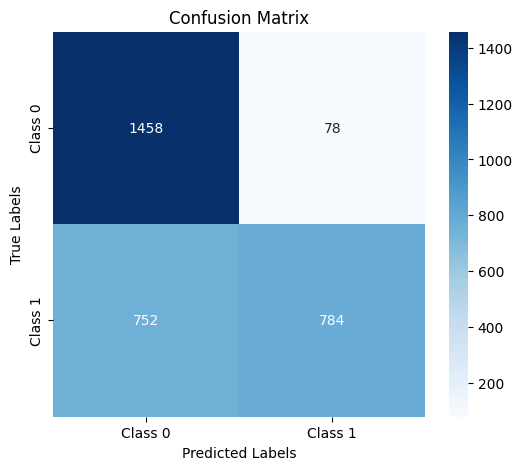

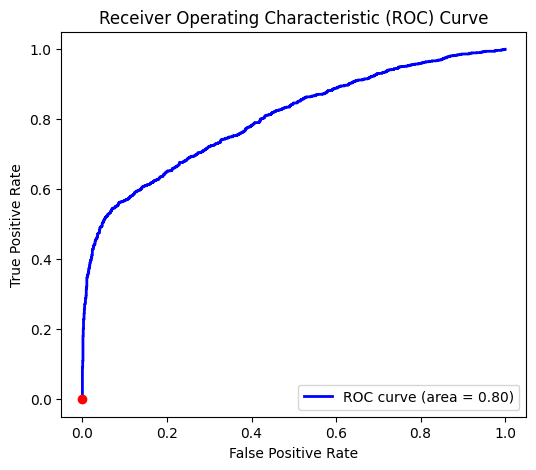

Accuracy: 0.73
Precision: 0.91
Recall: 0.51
F1 Score: 0.65
MCC: 0.51
ROC AUC: 0.80
Sensitivity: 0.51
Specificity: 0.95


In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import (confusion_matrix, roc_curve, roc_auc_score, accuracy_score,
                             precision_score, recall_score, f1_score, matthews_corrcoef)
import matplotlib.pyplot as plt
import seaborn as sns

# تعریف دیتاست سفارشی
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# تابع برای بارگذاری داده‌ها به عنوان DataLoader
def load_data_as_dataloader(data_files, labels, batch_size, percentage=1.0):
    all_data = []
    for file in data_files:
        data = np.load(file)
        all_data.append(data)
    data = np.concatenate(all_data, axis=0)
    num_samples = data.shape[0]

    subset_size = int(num_samples * percentage)
    data = data[:subset_size]
    labels = labels[:subset_size]

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# مدل جدید
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        lstm_out, _ = self.bilstm(x)
        lstm_out = lstm_out.transpose(0, 1)
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)
        lstm_out = self.fc2(lstm_out)
        return lstm_out

# تابع ارزیابی مدل
def evaluate_model(test_loader, model, device):
    model.eval()
    correct_test = 0
    total_test = 0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for test_X, test_y in test_loader:
            test_X, test_y = test_X.to(device), test_y.to(device)
            outputs = model(test_X)

            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())

            _, predicted = torch.max(outputs.data, 1)
            total_test += test_y.size(0)
            correct_test += (predicted == test_y).sum().item()

            all_labels.extend(test_y.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {accuracy:.2f}%")
    return all_labels, all_predictions, all_probs

# تابع محاسبه و رسم متریک‌ها
def calculate_metrics_and_plot(all_labels, all_predictions, all_probs, model_save_path):
    cm = confusion_matrix(all_labels, all_predictions)
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(f"{model_save_path}_confusion_matrix.png")
    plt.show()

    fpr, tpr, _ = roc_curve(all_labels, [prob[1] for prob in all_probs])
    roc_auc = roc_auc_score(all_labels, [prob[1] for prob in all_probs])

    plt.figure(figsize=(6, 5))
    # رسم از نقطه شروع واقعی
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([fpr[0]], [tpr[0]], 'ro')  # نشان دادن نقطه برخورد
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig(f"{model_save_path}_roc_curve.png")
    plt.show()

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    mcc = matthews_corrcoef(all_labels, all_predictions)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"MCC: {mcc:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")

# فایل‌های ورودی و مسیر مدل
model_save_path = '/content/drive/MyDrive/server15 azar 1/best_model_fold_9.pth'
test_data_files = [
    '/content/drive/MyDrive/my_project/LMPred_Embeddings/NEWUNIPRO/resized_X_TEST_batch_1.npy',
    '/content/drive/MyDrive/my_project/LMPred_Embeddings/NEWUNIPRO/resized_X_TEST_batch_2.npy',
    '/content/drive/MyDrive/my_project/LMPred_Embeddings/NEWUNIPRO/resized_X_TEST_batch_3.npy',
    '/content/drive/MyDrive/my_project/LMPred_Embeddings/NEWUNIPRO/resized_X_TEST_batch_4.npy'
]
test_label_file = '/content/drive/MyDrive/server15 azar 1/updated1_test_labels.csv'

# بارگذاری برچسب‌ها
test_labels = np.loadtxt(test_label_file, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader
test_loader = load_data_as_dataloader(test_data_files, test_labels, batch_size=32, percentage=1.0)

# بارگذاری مدل ذخیره‌شده
model = TransformerWithBiLSTM(input_dim=1024, num_classes=2)
model.load_state_dict(torch.load(model_save_path))

# انتقال مدل به GPU یا CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ارزیابی مدل
all_labels, all_predictions, all_probs = evaluate_model(test_loader, model, device)

# محاسبه و ذخیره نمودارها و متریک‌ها
calculate_metrics_and_plot(all_labels, all_predictions, all_probs, model_save_path)


In [ ]:
20 fold unipro(DS3)

<ipython-input-4-3d6f771a49bf>:160: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


Test Accuracy: 72.01%


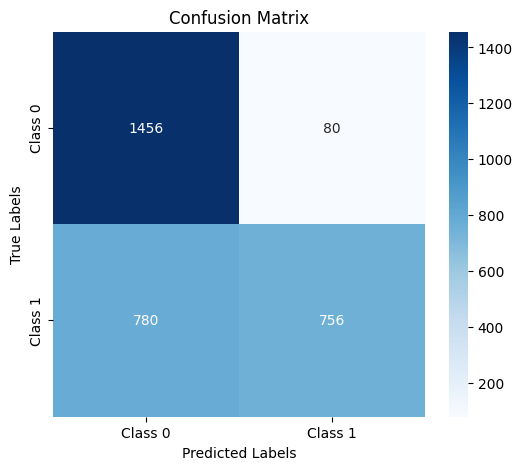

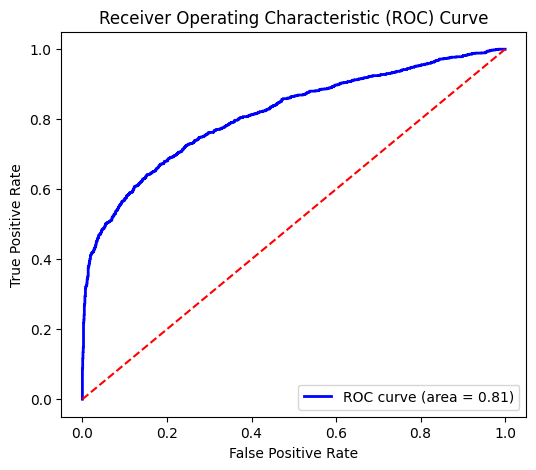

Accuracy: 0.72
Precision: 0.90
Recall (Sensitivity): 0.49
F1 Score: 0.64
MCC: 0.49
ROC AUC: 0.81
Sensitivity: 0.49
Specificity: 0.95


In [ ]:
import torch
import torch.nn as nn  # اضافه کردن این خط
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, roc_curve, roc_auc_score, accuracy_score,
                             precision_score, recall_score, f1_score, matthews_corrcoef)
from torch.utils.data import DataLoader, Dataset

# تعریف دیتاست سفارشی
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# تابع برای بارگذاری داده‌ها به عنوان DataLoader
def load_data_as_dataloader(data_files, labels, batch_size, percentage=1.0):
    all_data = []
    for file in data_files:
        data = np.load(file)
        all_data.append(data)
    data = np.concatenate(all_data, axis=0)
    num_samples = data.shape[0]

    subset_size = int(num_samples * percentage)
    data = data[:subset_size]
    labels = labels[:subset_size]

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# مدل ترنسفورمر با لایه‌های BiLSTM
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=2, lstm_hidden_dim=32, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        lstm_out, _ = self.bilstm(x)
        lstm_out = lstm_out.transpose(0, 1)
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)
        lstm_out = self.fc2(lstm_out)
        return lstm_out

# تابع ارزیابی مدل
def evaluate_model(test_loader, model, device):
    model.eval()
    correct_test = 0
    total_test = 0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for test_X, test_y in test_loader:
            test_X, test_y = test_X.to(device), test_y.to(device)
            outputs = model(test_X)

            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())

            _, predicted = torch.max(outputs.data, 1)
            total_test += test_y.size(0)
            correct_test += (predicted == test_y).sum().item()

            all_labels.extend(test_y.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {accuracy:.2f}%")
    return all_labels, all_predictions, all_probs

# تابع محاسبه و رسم متریک‌ها
def calculate_metrics_and_plot(all_labels, all_predictions, all_probs, model_save_path):
    cm = confusion_matrix(all_labels, all_predictions)
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(f"{model_save_path}_confusion_matrix.png")
    plt.show()

    fpr, tpr, _ = roc_curve(all_labels, [prob[1] for prob in all_probs])
    roc_auc = roc_auc_score(all_labels, [prob[1] for prob in all_probs])

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig(f"{model_save_path}_roc_curve.png")
    plt.show()

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    mcc = matthews_corrcoef(all_labels, all_predictions)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall (Sensitivity): {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"MCC: {mcc:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")

# فایل‌های ورودی و مسیر مدل
model_save_path = '/content/drive/MyDrive/server15 azar 1/best_model_fold_1.pth'
test_data_files = [
    '/content/drive/MyDrive/my_project/LMPred_Embeddings/NEWUNIPRO/resized_X_TEST_batch_1.npy',
    '/content/drive/MyDrive/my_project/LMPred_Embeddings/NEWUNIPRO/resized_X_TEST_batch_2.npy',
    '/content/drive/MyDrive/my_project/LMPred_Embeddings/NEWUNIPRO/resized_X_TEST_batch_3.npy',
    '/content/drive/MyDrive/my_project/LMPred_Embeddings/NEWUNIPRO/resized_X_TEST_batch_4.npy'
]
test_label_file = '/content/drive/MyDrive/server15 azar 1/updated1_test_labels.csv'

# بارگذاری برچسب‌ها
test_labels = np.loadtxt(test_label_file, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader
test_loader = load_data_as_dataloader(test_data_files, test_labels, batch_size=32, percentage=1.0)

# بارگذاری مدل ذخیره‌شده
model = TransformerWithBiLSTM(input_dim=1024, num_classes=2)
model.load_state_dict(torch.load(model_save_path))

# انتقال مدل به GPU یا CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ارزیابی مدل
all_labels, all_predictions, all_probs = evaluate_model(test_loader, model, device)

# محاسبه و ذخیره نمودارها و متریک‌ها
calculate_metrics_and_plot(all_labels, all_predictions, all_probs, model_save_path)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
<ipython-input-5-733ff3572c76>:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only

Test Accuracy: 71.32%


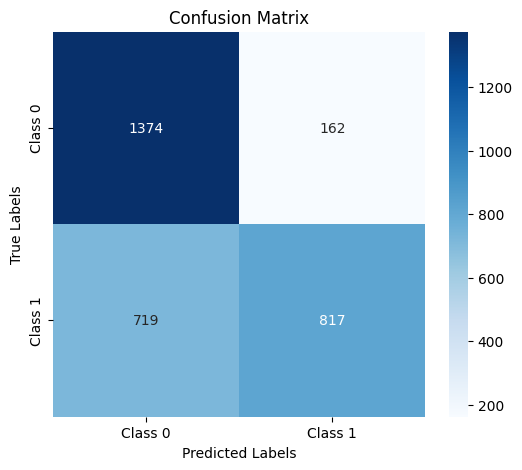

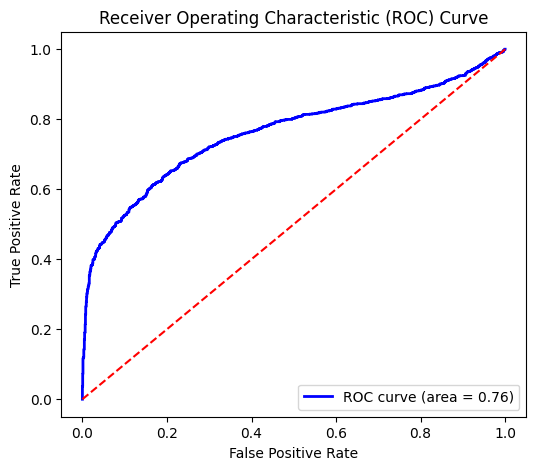

Accuracy: 0.71
Precision: 0.83
Recall (Sensitivity): 0.53
F1 Score: 0.65
MCC: 0.46
ROC AUC: 0.76
Sensitivity: 0.53
Specificity: 0.89


In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import (confusion_matrix, roc_curve, roc_auc_score, accuracy_score,
                             precision_score, recall_score, f1_score, matthews_corrcoef)
import matplotlib.pyplot as plt
import seaborn as sns

# تعریف دیتاست سفارشی
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# تابع برای بارگذاری داده‌ها به عنوان DataLoader
def load_data_as_dataloader(data_files, labels, batch_size, percentage=1.0):
    all_data = []
    for file in data_files:
        data = np.load(file)
        all_data.append(data)
    data = np.concatenate(all_data, axis=0)
    num_samples = data.shape[0]

    subset_size = int(num_samples * percentage)
    data = data[:subset_size]
    labels = labels[:subset_size]

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# مدل ترنسفورمر با لایه‌های BiLSTM
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=4, num_layers=1, lstm_hidden_dim=64, dropout_rate=0.5):
        super(TransformerWithBiLSTM, self).__init__()

        # لایه BiLSTM
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        # لایه‌های MultiheadAttention
        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        # لایه نرمال‌سازی و Fully Connected
        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 64)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        lstm_out, _ = self.bilstm(x)

        # عبور از لایه‌های ترنسفورمر
        lstm_out = lstm_out.transpose(0, 1)  # سازگاری با شکل مورد نیاز MultiheadAttention
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)  # بازگشت به شکل اولیه
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)  # Global Average Pooling
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)
        lstm_out = self.fc2(lstm_out)  # خروجی نهایی
        return lstm_out

# تابع ارزیابی مدل
def evaluate_model(test_loader, model, device):
    model.eval()
    correct_test = 0
    total_test = 0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for test_X, test_y in test_loader:
            test_X, test_y = test_X.to(device), test_y.to(device)
            outputs = model(test_X)

            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())

            _, predicted = torch.max(outputs.data, 1)
            total_test += test_y.size(0)
            correct_test += (predicted == test_y).sum().item()

            all_labels.extend(test_y.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {accuracy:.2f}%")
    return all_labels, all_predictions, all_probs

# تابع محاسبه و رسم متریک‌ها
def calculate_metrics_and_plot(all_labels, all_predictions, all_probs, model_save_path):
    cm = confusion_matrix(all_labels, all_predictions)
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(f"{model_save_path}_confusion_matrix.png")
    plt.show()

    fpr, tpr, _ = roc_curve(all_labels, [prob[1] for prob in all_probs])
    roc_auc = roc_auc_score(all_labels, [prob[1] for prob in all_probs])

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig(f"{model_save_path}_roc_curve.png")
    plt.show()

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    mcc = matthews_corrcoef(all_labels, all_predictions)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall (Sensitivity): {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"MCC: {mcc:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")

# فایل‌های ورودی و مسیر مدل
model_save_path = '/content/drive/MyDrive/server15 azar 1/transformer_bilstmunipro0-11_model.pth'
test_data_files = [
    '/content/drive/MyDrive/my_project/LMPred_Embeddings/NEWUNIPRO/resized_X_TEST_batch_1.npy',
    '/content/drive/MyDrive/my_project/LMPred_Embeddings/NEWUNIPRO/resized_X_TEST_batch_2.npy',
    '/content/drive/MyDrive/my_project/LMPred_Embeddings/NEWUNIPRO/resized_X_TEST_batch_3.npy',
    '/content/drive/MyDrive/my_project/LMPred_Embeddings/NEWUNIPRO/resized_X_TEST_batch_4.npy'
]
test_label_file = '/content/drive/MyDrive/server15 azar 1/updated1_test_labels.csv'

# بارگذاری برچسب‌ها
test_labels = np.loadtxt(test_label_file, delimiter=',', dtype=int)

# آماده‌سازی داده‌ها به عنوان DataLoader
test_loader = load_data_as_dataloader(test_data_files, test_labels, batch_size=32, percentage=1.0)

# بارگذاری مدل ذخیره‌شده
model = TransformerWithBiLSTM(input_dim=1024, num_classes=2)
model.load_state_dict(torch.load(model_save_path))

# انتقال مدل به GPU یا CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ارزیابی مدل
all_labels, all_predictions, all_probs = evaluate_model(test_loader, model, device)

# محاسبه و ذخیره نمودارها و متریک‌ها
calculate_metrics_and_plot(all_labels, all_predictions, all_probs, model_save_path)


test DS(6)

The dataset we used for training had an independent test set, and we performed testing using the same independent test set.


In [ ]:
import zipfile
import os

# مسیر فایل ZIP
zip_path = "/content/drive/MyDrive/20 AZARRNN/TEST.zip"

# مسیر دایرکتوری برای خارج کردن فایل‌ها
extract_path = os.path.dirname(zip_path)  # استخراج در همان مسیر فایل ZIP

# خارج کردن فایل‌ها
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")


Files extracted to: /content/drive/MyDrive/20 AZARRNN


<ipython-input-8-a6984802879b>:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/20 AZARRNN/transformer_bilstm_mode

Test Accuracy: 96.33%


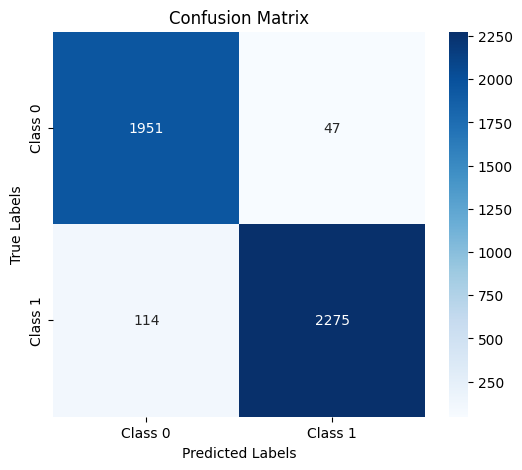

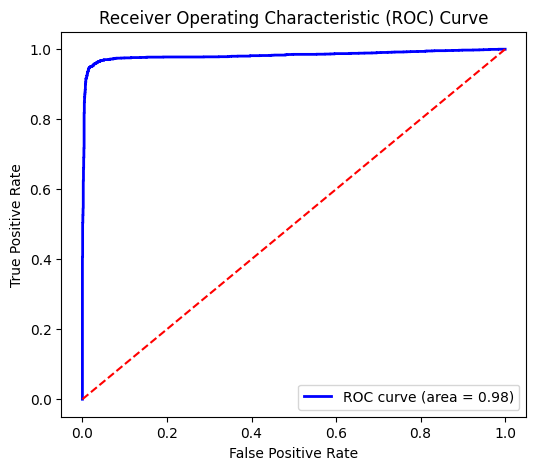

Accuracy: 0.96
Precision: 0.98
Recall (Sensitivity): 0.95
F1 Score: 0.97
MCC: 0.93
ROC AUC: 0.98
Sensitivity: 0.95
Specificity: 0.98


In [ ]:


import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, roc_curve, roc_auc_score, accuracy_score,
                             precision_score, recall_score, f1_score, matthews_corrcoef)
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

# تعریف دیتاست سفارشی
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# تابع برای بارگذاری داده‌ها به عنوان DataLoader
def load_data_as_dataloader(file_paths, labels, batch_size, percentage=1.0):
    data = []
    for file_path in file_paths:
        data.append(np.load(file_path, mmap_mode='r'))
    data = np.concatenate(data, axis=0)

    num_samples = data.shape[0]
    subset_size = int(num_samples * percentage)
    data = data[:subset_size]
    labels = labels[:subset_size]

    dataset = CustomDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# مدل ترنسفورمر با لایه‌های BiLSTM
class TransformerWithBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=4, num_layers=3, lstm_hidden_dim=128, dropout_rate=0.3):
        super(TransformerWithBiLSTM, self).__init__()

        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=lstm_hidden_dim,
                              num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=lstm_hidden_dim * 2, num_heads=num_heads) for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(lstm_hidden_dim * 2)
        self.fc1 = nn.Linear(lstm_hidden_dim * 2, 256)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        lstm_out, _ = self.bilstm(x)
        lstm_out = lstm_out.transpose(0, 1)
        for attention in self.attention_layers:
            lstm_out, _ = attention(lstm_out, lstm_out, lstm_out)

        lstm_out = lstm_out.transpose(0, 1)
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = torch.relu(self.fc1(lstm_out))
        lstm_out = self.dropout(lstm_out)
        lstm_out = self.fc2(lstm_out)
        return lstm_out

# تابع ارزیابی مدل
def evaluate_model(test_loader, model, device):
    model.eval()
    correct_test = 0
    total_test = 0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for test_X, test_y in test_loader:
            test_X, test_y = test_X.to(device), test_y.to(device)
            outputs = model(test_X)
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            _, predicted = torch.max(outputs.data, 1)
            total_test += test_y.size(0)
            correct_test += (predicted == test_y).sum().item()
            all_labels.extend(test_y.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {accuracy:.2f}%")
    return all_labels, all_predictions, all_probs

# محاسبه و رسم متریک‌ها
def calculate_metrics_and_plot(all_labels, all_predictions, all_probs, plot_save_path):
    cm = confusion_matrix(all_labels, all_predictions)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(f"{plot_save_path}_confusion_matrix.png")
    plt.show()

    fpr, tpr, _ = roc_curve(all_labels, [prob[1] for prob in all_probs])
    roc_auc = roc_auc_score(all_labels, [prob[1] for prob in all_probs])

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig(f"{plot_save_path}_roc_curve.png")
    plt.show()

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    mcc = matthews_corrcoef(all_labels, all_predictions)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall (Sensitivity): {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"MCC: {mcc:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")

# مسیر داده تست و مدل
test_files = [
    '/content/drive/MyDrive/20 AZARRNN/resized_X_TEST_batch_1.npy',
    '/content/drive/MyDrive/20 AZARRNN/resized_X_TEST_batch_2.npy',
    '/content/drive/MyDrive/20 AZARRNN/resized_X_TEST_batch_3.npy',
    '/content/drive/MyDrive/20 AZARRNN/resized_X_TEST_batch_4.npy',
    '/content/drive/MyDrive/20 AZARRNN/resized_X_TEST_batch_5.npy'
]
test_labels = np.loadtxt('/content/drive/MyDrive/20 AZARRNN/test_labels.csv', delimiter=',', dtype=int)

# بارگذاری داده‌ها
test_loader = load_data_as_dataloader(test_files, test_labels, batch_size=32)

# بارگذاری مدل
model = TransformerWithBiLSTM(input_dim=1024, num_classes=2)
model.load_state_dict(torch.load('/content/drive/MyDrive/20 AZARRNN/transformer_bilstm_model.pth'))

# انتقال به GPU یا CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ارزیابی مدل
all_labels, all_predictions, all_probs = evaluate_model(test_loader, model, device)

# ذخیره نمودارها و متریک‌ها
calculate_metrics_and_plot(all_labels, all_predictions, all_probs, '/content/drive/MyDrive/20 AZARRNN/evaluation_plots')


